In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from os import listdir
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation as FA

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

📌 Loading the data:

There are 100 trajectories of engine degradation in EACH of the datasets (train and test).  
For the train data, each engine is run from a certain normal condition till failure.  
For the test data, each engine is NOT run until failure (or we have data until a specific point of the engine's state). The amount of time cycles left for this engine to still be 'normal' is what we call RUL, or Remaining Useful Lifetime.
> **Predicting what the RUL is for the last state of each machine in the test set will be our prediction task.**

In [2]:
data_dir = "datasets"

listdir(data_dir)

file_name = 'FD001.txt'

# Use os.path.join for cross-platform compatibility
train_file_path = os.path.join(data_dir, 'train_' + file_name)
test_file_path = os.path.join(data_dir, 'test_' + file_name)
rul_file_path = os.path.join(data_dir, 'RUL_' + file_name)

# Load data using the new paths
df_train = pd.read_csv(train_file_path, header = None, sep = r'\s+')
df_test = pd.read_csv(test_file_path, header = None, sep = r'\s+')
rul_test = pd.read_csv(rul_file_path, header = None)

for df in [df_train, df_test, rul_test]:
    display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


,0
0,112
1,98
2,69
3,82
4,91


📌 Attaching column names: We have three operational setting columns (**os + number**), and 21 sensor columns (**s + number**). We have dropped the last two columns containing NaNs.

In [3]:
col_names = []

col_names.append('unit')
col_names.append('time')

for i in range(1,4):
    col_names.append('os'+str(i))
for i in range(1,22):
    col_names.append('s'+str(i))

df_train.columns = col_names
display(df_train.head())

df_test.columns = col_names
display(df_test.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


📌 Attaching RUL(remaining useful lifetime) values to the datasets.

For the train data, the RUL values are not specified, but the document regarding this dataset specifies that for the training data, all the engines were run to failure. Thus, for example, if we had five rows for a specific unit, say unit 7:

|unit|time cycle|
|--|--|
|7|1|
|7|2|
|7|3|
|7|4|
|7|5|

Then we know that the last row is when the RUL value becomes 0 (failure), so the RUL for this unit would be attached in this way:

|unit|time cycle|RUL|
|--|--|--|
|7|1|**4**|
|7|2|**3**|
|7|3|**2**|
|7|4|**1**|
|7|5|**0**|

For the test data, we have the 'solutions' for the test engines in a separate file called rul_test (the name that I used for dataframe). I will use that to attach the RUL values for the test as well.

In [4]:
max(df_train['unit'])

100

In [5]:
rul_list = []
engine_numbers = max(df_train['unit'])
for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_train[df_train['unit'] == n]['time'])
    length = len(time_list)
    rul = list(length - time_list)
    rul_list += rul
    
df_train['rul'] = rul_list

rul_list = []

for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_test[df_test['unit'] == n]['time'])
    length = len(time_list)
    rul_val = rul_test.iloc[n-1].item()
    rul = list(length - time_list + rul_val)
    rul_list += rul

df_test['rul'] = rul_list

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


Below, we can see an example of all the sensor values of a specific engine in the training set (unit 4), as the engine progresses toward failure.

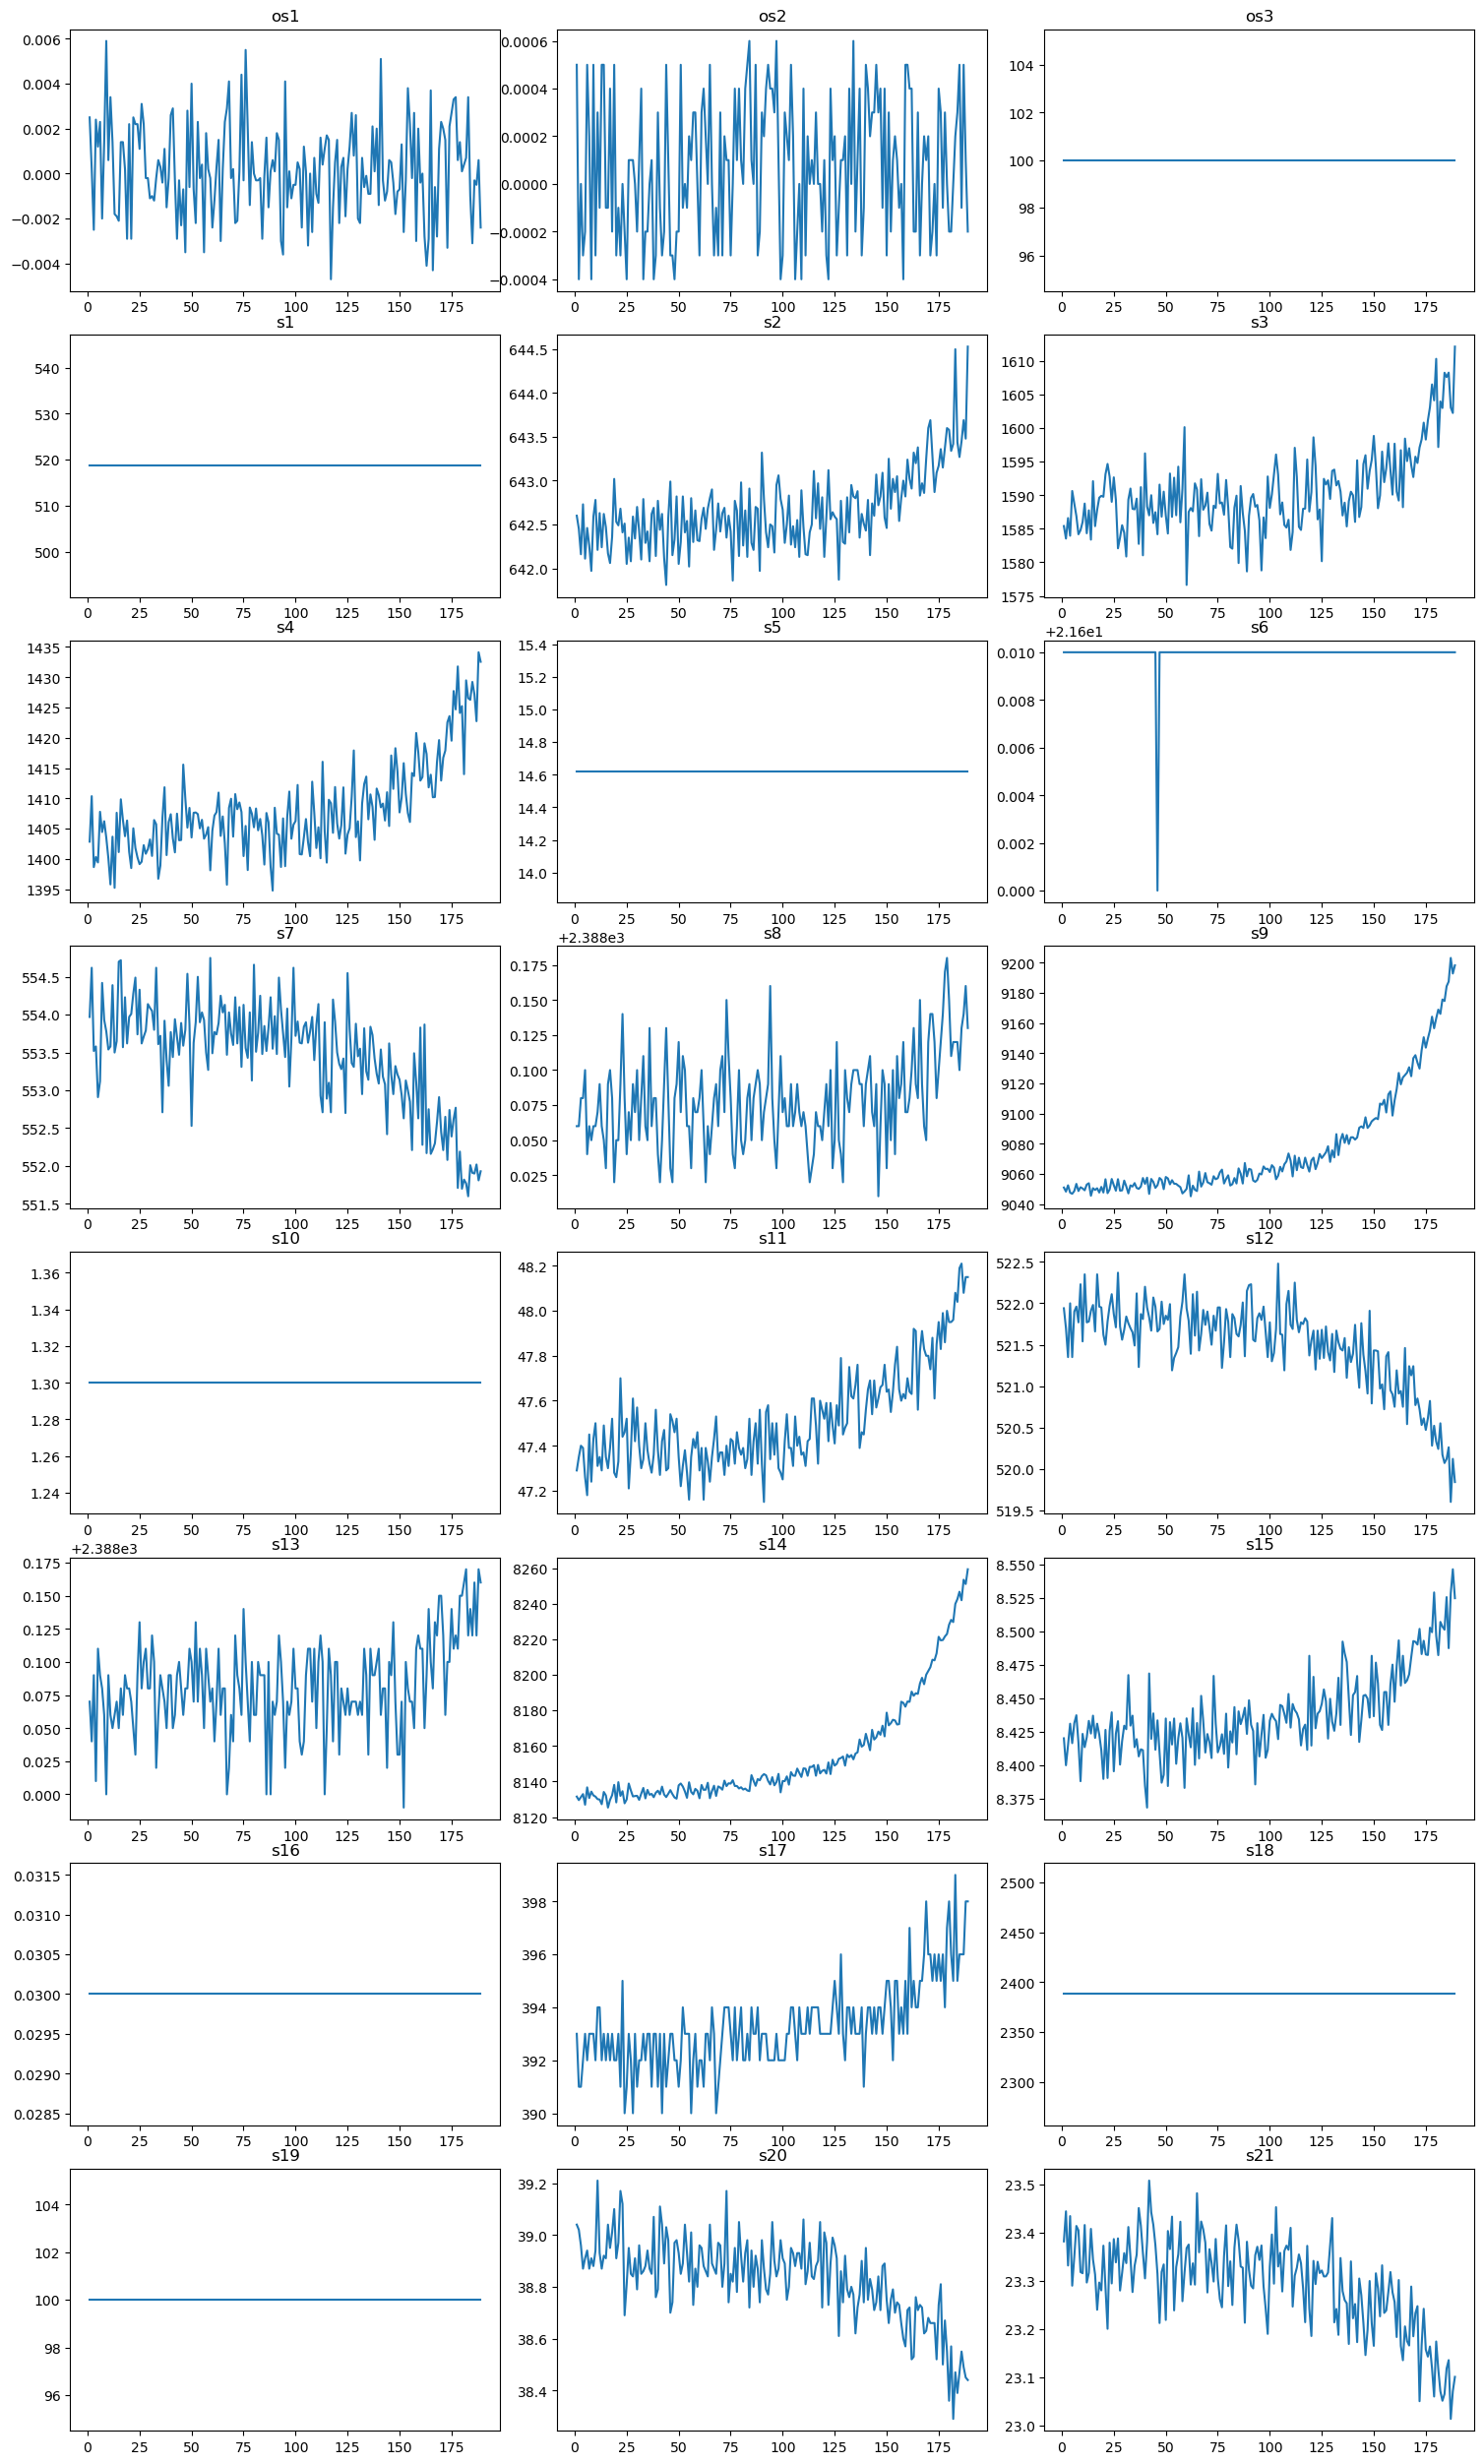

In [6]:
sample = 4
sample_df = df_train[df_train['unit'] == sample].copy()

fig, axes = plt.subplots(8,3, figsize = (15,25))
fig.tight_layout()

j = -1
for c in df_train.columns:
    
    if 's' in c:
        j += 1
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c])
        axes[j // 3, j % 3].set_title(c)

save_dir = "plots"
filename_dist = os.path.join(save_dir, f"feature_distributions_engine_4.png")
plt.savefig(filename_dist, dpi=600, bbox_inches='tight')

We plot the sensor data obtained from sensor 2 for 5 of the engines to show a general trend.


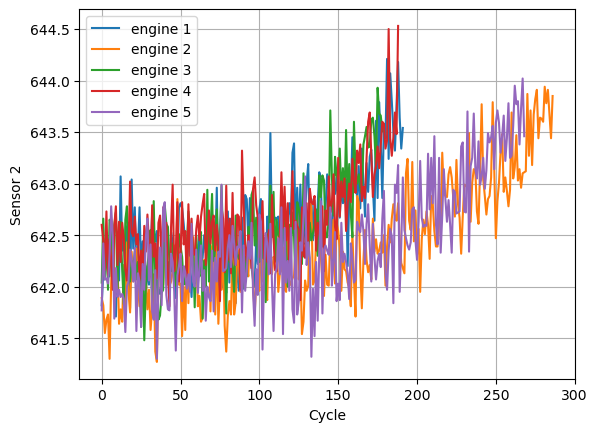

In [7]:
sensor = 's2'
for sample in range(1,6):
    sample_df = df_train[df_train['unit'] == sample].copy()
    sensordata = sample_df[sensor].to_numpy()
    plt.plot(sensordata, label = "engine "+str(sample))
plt.grid()
plt.legend()
plt.ylabel('Sensor 2')
plt.xlabel('Cycle')
plt.show()

We can notice here, that there are multiple sensors which are not changing its value. Perhaps, they are not useful features for prediction. Would they have similar behaviors for other engine units as well? Below show that yes (standard deviation is 0, or practically 0).

In [8]:
df_train[['os3','s1','s5','s6','s10','s16','s18','s19']].describe()

,os3,s1,s5,s6,s10,s16,s18,s19
count,20631.0,20631.00,2.063100e+04,20631.000000,20631.0,2.063100e+04,20631.0,20631.0
mean,100.0,518.67,1.462000e+01,21.609803,1.3,3.000000e-02,2388.0,100.0
std,0.0,0.00,1.776400e-15,0.001389,0.0,1.387812e-17,0.0,0.0
min,100.0,518.67,1.462000e+01,21.600000,1.3,3.000000e-02,2388.0,100.0
25%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
50%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
75%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
max,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0


📌 Previously mentioned columns are dropped.

In [9]:
#Drop os3, s1, s5, s6, s10, s16, s18, s19 from both train and test
drop_cols1 = ['os3','s1','s5','s6','s10','s16','s18','s19']

df_train = df_train.drop(drop_cols1, axis = 1)
df_test = df_test.drop(drop_cols1, axis = 1)

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138


📌 Sensor values are Min-Max scaled.

$$scaled = \frac{original - min}{max - min}$$

Here, we apply the same max and min values (from the training set) to the test set.

In [10]:
#Minmax Scaling
minmax_dict = {}

for c in df_train.columns:
    if 's' in c:
        minmax_dict[c+'min'] = df_train[c].min()
        minmax_dict[c+'max']=  df_train[c].max()
        
for c in df_train.columns:
    if 's' in c:
        df_train[c] = (df_train[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for c in df_test.columns:
    if 's' in c:
        df_test[c] = (df_test[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,138


📌 The time series for sensor values were noisy. If the time-series values are $t_1, t_2, t_3, ..., t_n$, then the smoothed values $v_1, v_2, ..., v_n$ with the parameter $\beta$ follow the following formula:

$$v_0 = 0, v_{t} = \frac{\beta v_{t-1} + (1-\beta) x_{t}}{1-\beta^{t}}$$

In [11]:
#Smoothing Function: Exponentially Weighted Averages

def smooth(s, b = 0.98):

    v = np.zeros(len(s)+1) #v_0 is already 0.
    bc = np.zeros(len(s)+1)

    for i in range(1, len(v)): #v_t = 0.95
        v[i] = (b * v[i-1] + (1-b) * s[i-1]) 
        bc[i] = 1 - b**i

    sm = v[1:] / bc[1:]
    
    return sm

s = [1,2,3,4,5]
print(s)
print(f'After Smoothing: {smooth(s)}')

[1, 2, 3, 4, 5]
After Smoothing: [1.         1.50505051 2.01346756 2.52525046 3.04039827]


In [12]:
#Smoothing each time series for each engine in both training and test sets

for c in df_train.columns:
    
    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_train[df_train['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm
        
        df_train[c+'_smoothed'] = sm_list
        
for c in df_test.columns:
    
    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_test[df_test['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm
        
        df_test[c+'_smoothed'] = sm_list

Let's take a look at how smoothed values (salmon) look compared to the original series (lightblue), for a particular sensor (unit 10 from train)

In [13]:
df_train.columns

Index(['unit', 'time', 'os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11',
       's12', 's13', 's14', 's15', 's17', 's20', 's21', 'rul', 'os1_smoothed',
       'os2_smoothed', 's2_smoothed', 's3_smoothed', 's4_smoothed',
       's7_smoothed', 's8_smoothed', 's9_smoothed', 's11_smoothed',
       's12_smoothed', 's13_smoothed', 's14_smoothed', 's15_smoothed',
       's17_smoothed', 's20_smoothed', 's21_smoothed'],
      dtype='object')

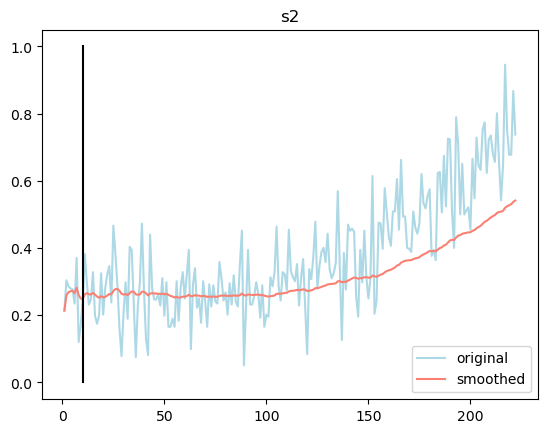

In [14]:
sample = 10
sample_df = df_train[df_train['unit'] == sample].copy()

# fig, axes = plt.subplots(6,3, figsize = (15,25))
fig = plt.figure()
# fig.tight_layout()

j = -1
c = 's2'
plt.plot(sample_df['time'], sample_df[c], c = 'lightblue', label = 'original')
plt.plot(sample_df['time'], sample_df[c+'_smoothed'], c = 'salmon', label = 'smoothed')
plt.plot([10,10],[0,1], c = 'black')
plt.title(c)
plt.legend()

save_dir = "plots"
filename_dist = os.path.join(save_dir, f"s2 original_vs_smoothed_values")
plt.savefig(filename_dist, dpi=300, bbox_inches='tight')

# for c in df_train.columns:
    
#     if ('s' in c) and ('smoothed' not in c):
#         j += 1
#         axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c], c = 'lightblue', label = 'original')
#         axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c+'_smoothed'], c = 'salmon', label = 'smoothed')
#         axes[j // 3, j % 3].plot([10,10],[0,1], c = 'black')
#         axes[j // 3, j % 3].set_title(c)
#         axes[j // 3, j % 3].legend()

In [15]:
#Remove the original series

for c in df_train.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_train[c] = df_train[c+'_smoothed']
        df_train.drop(c+'_smoothed', axis = 1, inplace = True)
        
for c in df_test.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_test[c] = df_test[c+'_smoothed']
        df_test.drop(c+'_smoothed', axis = 1, inplace = True)
        
for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.535237,0.208754,0.233936,0.430144,0.331412,0.676638,0.227120,0.104951,0.375060,0.700028,0.243018,0.181025,0.387888,0.333333,0.689688,0.727870,190
2,1,3,0.439208,0.392826,0.271154,0.409527,0.344714,0.688033,0.242630,0.116885,0.332528,0.732432,0.235390,0.177885,0.377535,0.276652,0.668677,0.691652,189
3,1,4,0.465234,0.420437,0.289760,0.370016,0.341231,0.701612,0.262094,0.118852,0.289798,0.772801,0.250520,0.177113,0.323193,0.291254,0.644194,0.684112,188
4,1,5,0.449741,0.402305,0.302174,0.346587,0.354428,0.694673,0.258000,0.125327,0.282753,0.767278,0.247350,0.176618,0.339614,0.317360,0.632735,0.688357,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.487054,0.497475,0.345899,0.345454,0.245626,0.729436,0.189164,0.137245,0.298521,0.693438,0.242870,0.168831,0.260578,0.375421,0.620781,0.674457,141
2,1,3,0.497321,0.526674,0.356308,0.345854,0.271685,0.714661,0.202125,0.144331,0.328579,0.695452,0.235292,0.164345,0.327936,0.389448,0.657477,0.690404,140
3,1,4,0.560197,0.519802,0.359960,0.330216,0.306804,0.705615,0.200797,0.134383,0.309869,0.664050,0.239081,0.165825,0.309667,0.353523,0.659845,0.683115,139
4,1,5,0.564415,0.515680,0.366539,0.334768,0.312057,0.703206,0.193692,0.127725,0.302363,0.679389,0.235232,0.163103,0.307839,0.314626,0.659651,0.690038,138


📌 When we look at the length of the trajectories for each unit in both the training and test sets, thus 200 engines, we see that for the training set that had the entire trajectories, have minimum length of 128. However, for the test set, we have a minimum value of 31. This means that if we were to predict the final RUL for every test engine unit, we cannot use a window size greater than 31 for training the model. Furthermore, if you take a look at the smoothed series visualization, I put a **black** vertical line for every graph, at about time step 10. This is because, when we smooth using exponentially weighted averages, seems like in the beginning, it seems a little shaky. Thus, I will be taking that part out of the training process. This will happen for test data as well. Thus, the maximum window size we can take is 31 - 10 = 21. I will go with **20**.

In [16]:
print('training set time cycles:')
display(df_train.groupby('unit')['time'].max().describe())
print('test set time cycles:')
display(df_test.groupby('unit')['time'].max().describe())

training set time cycles:


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time, dtype: float64

test set time cycles:


count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: time, dtype: float64

In [17]:
n_features = len([c for c in df_train.columns if 's' in c]) #plus one for time
window = 20
print(f'number of features: {n_features}, window size: {window}')

number of features: 16, window size: 20


📌 Splitting **Train and Validation** Sets: Out of the 100 engines in the training set, I will randomly take out 20 engines for validation.

In [18]:
np.random.seed(SEED)
units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))
print(val_units)

[2, 6, 7, 10, 12, 13, 17, 19, 21, 26, 29, 30, 38, 51, 65, 72, 73, 76, 77, 80]


📌 Prepare Training, Validation and Test Dataloaders.

For training process, I will take batches of 64.  
For the validation process, I will take the entire validation set (all the windows avaiable).
For the test process, I will take the LAST window of each engine's given trajectory, thus it will have exactly 100 X(size 20 window)s and 100 y(RUL)s.

In [19]:
train_data = df_train[df_train['unit'].isin(train_units)].copy()
val_data = df_train[df_train['unit'].isin(val_units)].copy()

train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

In [20]:
class data(Dataset):
    
    def __init__(self, list_indices, df_train):
        
        self.indices = list_indices
        self.df_train = df_train
        
    def __len__(self):
        
        return len(self.indices)
    
    def __getitem__(self, idx):
        
        ind = self.indices[idx]
        X_ = self.df_train.iloc[ind : ind + 20, :].drop(['time','unit','rul'], axis = 1).copy().to_numpy()
        y_ = self.df_train.iloc[ind + 19]['rul']
        
        return X_, y_
    
g = torch.Generator()
g.manual_seed(SEED)
    
train = data(train_indices, df_train)
val = data(val_indices, df_train)

trainloader = DataLoader(train, batch_size = 64, shuffle = True)
valloader = DataLoader(val, batch_size = len(val_indices), shuffle = True)

units = np.arange(1,101)

class test(Dataset):
    
    def __init__(self, units, df_test):
        
        self.units = units
        self.df_test = df_test
        
    def __len__(self):
        
        return len(self.units)
    
    def __getitem__(self, idx):
        
        n = self.units[idx]
        U = self.df_test[self.df_test['unit'] == n].copy()
        X_ = U.reset_index().iloc[-20:,:].drop(['time','index','unit','rul'], axis = 1).copy().to_numpy()
        y_ = U['rul'].min()
        
        return X_, y_
    
test = test(units, df_test)
testloader = DataLoader(test, batch_size = 100, shuffle = True)

In [21]:
dataiter = iter(trainloader)
x,y = next(dataiter)
x.shape

torch.Size([64, 20, 16])

## 2. Model Building and Training ##

📌 I will be using a LSTM Model, with some linear - relu layers before the final output.

In [22]:
## Custom loss function
class CustomLoss(nn.Module):
    def __init__(self, alpha):
        super(CustomLoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        return torch.mean((predictions - targets) ** 2) + self.alpha*(torch.mean(torch.relu(predictions-targets)))

In [23]:
import matplotlib.pyplot as pyplot


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cuda'
# device = 'cpu'


class LSTMRegressor(nn.Module):
    
    def __init__(self, n_features, hidden_units):
        super().__init__()
        self.n_features = n_features
        self.hidden_units = hidden_units
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size = n_features, hidden_size = self.hidden_units, batch_first = True, num_layers = self.n_layers)
        self.linear1 = nn.Linear(in_features=self.hidden_units, out_features=12)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=12, out_features=12)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=12, out_features=1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_units,device=x.device).requires_grad_()
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_units,device=x.device).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear1(hn[0])
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out).flatten()
        
        return out
    
learning_rate = 0.001
n_hidden_units = 12

torch.manual_seed(SEED)

model = LSTMRegressor(n_features, n_hidden_units).to(device)
# loss_fn = nn.MSELoss()
alpha = 0.4
loss_fn = CustomLoss(alpha)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                             
ks = [key for key in model.state_dict().keys() if 'linear' in key and '.weight' in key]

for k in ks:
    nn.init.kaiming_uniform_(model.state_dict()[k])
    
bs = [key for key in model.state_dict().keys() if 'linear' in key and '.bias' in key]

for b in bs:
    nn.init.constant_(model.state_dict()[b], 0)

📌 Validation and Test Functions

In [25]:
def validation():
    
    model.eval()
    X, y = next(iter(valloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
    
    with torch.no_grad():
        y_pred = model(X)
        val_loss = loss_fn(y_pred, y).item()
        
    return val_loss

loss_L1 = nn.L1Loss()
    
def test():
    model.eval()
    X, y = next(iter(testloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
    
    with torch.no_grad():
        y_pred = model(X)
        # y_pred = torch.round(y_pred)
        test_loss_MSE = torch.mean((y_pred - y) ** 2).item() #loss_fn(y_pred, y).item()
        test_loss_L1 = loss_L1(y_pred, y).item()
        test_ASUE = (torch.mean(torch.relu(y-y_pred))).item()
        
    return test_loss_MSE, test_loss_L1, test_ASUE, y_pred, y

📌 Training Loop: I have trained using Adam Optimizer for 35 epochs with learning rate = 0.001

In [26]:
T = []
V = []
epochs = 35

loss_fn = nn.MSELoss()
for i in tqdm(range(epochs)):
    
    L = 0
    model.train()
    
    for batch, (X,y) in enumerate(trainloader):
        
        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        L += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # alpha = alpha*(1 +((y<y_pred).count_nonzero().item()/len(y)+0.5))
        # loss_fn = CustomLoss(alpha)
        # print(alpha)
    val_loss = validation()
    
    T.append(L/len(trainloader))
    V.append(val_loss)
    (y<y_pred).count_nonzero().item()/len(y)
    # if (i+1) % 10 == 0:
    #     sleep(0.5)
    print(f'epoch:{i+1}, avg_train_loss:{L/len(trainloader)}, val_loss:{val_loss}')

  3%|██▎                                                                                | 1/35 [00:14<08:21, 14.74s/it]

epoch:1, avg_train_loss:10069.221533639091, val_loss:4432.95947265625


  6%|████▋                                                                              | 2/35 [00:28<07:56, 14.44s/it]

epoch:2, avg_train_loss:4243.2144284929545, val_loss:3251.011474609375


  9%|███████                                                                            | 3/35 [00:43<07:43, 14.47s/it]

epoch:3, avg_train_loss:3909.0606569562638, val_loss:2781.2919921875


 11%|█████████▍                                                                         | 4/35 [00:57<07:27, 14.44s/it]

epoch:4, avg_train_loss:3052.903750828334, val_loss:1574.791748046875


 14%|███████████▊                                                                       | 5/35 [01:12<07:12, 14.43s/it]

epoch:5, avg_train_loss:2282.3403843470983, val_loss:1249.430419921875


 17%|██████████████▏                                                                    | 6/35 [01:26<06:58, 14.42s/it]

epoch:6, avg_train_loss:2074.880672999791, val_loss:1495.104736328125


 20%|████████████████▌                                                                  | 7/35 [01:41<06:43, 14.42s/it]

epoch:7, avg_train_loss:1919.593668801444, val_loss:1178.47705078125


 23%|██████████████████▉                                                                | 8/35 [01:55<06:29, 14.41s/it]

epoch:8, avg_train_loss:1742.4106595175606, val_loss:968.527587890625


 26%|█████████████████████▎                                                             | 9/35 [02:09<06:13, 14.36s/it]

epoch:9, avg_train_loss:1505.2916122164045, val_loss:735.0599975585938


 29%|███████████████████████▍                                                          | 10/35 [02:24<05:58, 14.36s/it]

epoch:10, avg_train_loss:1320.8989088875908, val_loss:1145.98583984375


 31%|█████████████████████████▊                                                        | 11/35 [02:38<05:44, 14.37s/it]

epoch:11, avg_train_loss:1213.817761012486, val_loss:715.7056274414062


 34%|████████████████████████████                                                      | 12/35 [02:52<05:30, 14.38s/it]

epoch:12, avg_train_loss:1142.2755765914917, val_loss:592.1909790039062


 37%|██████████████████████████████▍                                                   | 13/35 [03:07<05:16, 14.39s/it]

epoch:13, avg_train_loss:1093.8154997144427, val_loss:760.382080078125


 40%|████████████████████████████████▊                                                 | 14/35 [03:21<05:02, 14.39s/it]

epoch:14, avg_train_loss:1037.4679869243078, val_loss:675.7750244140625


 43%|███████████████████████████████████▏                                              | 15/35 [03:36<04:47, 14.39s/it]

epoch:15, avg_train_loss:1011.3830618177142, val_loss:594.5474243164062


 46%|█████████████████████████████████████▍                                            | 16/35 [03:50<04:33, 14.38s/it]

epoch:16, avg_train_loss:987.3605685915265, val_loss:850.9266967773438


 49%|███████████████████████████████████████▊                                          | 17/35 [04:04<04:18, 14.34s/it]

epoch:17, avg_train_loss:1005.1230313437326, val_loss:707.5249633789062


 51%|██████████████████████████████████████████▏                                       | 18/35 [04:19<04:04, 14.36s/it]

epoch:18, avg_train_loss:964.6291969844273, val_loss:595.1533203125


 54%|████████████████████████████████████████████▌                                     | 19/35 [04:33<03:49, 14.36s/it]

epoch:19, avg_train_loss:945.6263561248779, val_loss:722.2203369140625


 57%|██████████████████████████████████████████████▊                                   | 20/35 [04:47<03:35, 14.37s/it]

epoch:20, avg_train_loss:966.1760371071952, val_loss:888.853271484375


 60%|█████████████████████████████████████████████████▏                                | 21/35 [05:02<03:21, 14.36s/it]

epoch:21, avg_train_loss:1000.4698130743844, val_loss:693.602783203125


 63%|███████████████████████████████████████████████████▌                              | 22/35 [05:16<03:06, 14.34s/it]

epoch:22, avg_train_loss:903.3033302852085, val_loss:601.060546875


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [05:30<02:51, 14.33s/it]

epoch:23, avg_train_loss:910.3520847048078, val_loss:696.0681762695312


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [05:44<02:37, 14.28s/it]

epoch:24, avg_train_loss:888.236366544451, val_loss:612.9685668945312


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [05:59<02:22, 14.26s/it]

epoch:25, avg_train_loss:875.4520899908883, val_loss:634.4005126953125


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [06:13<02:08, 14.22s/it]

epoch:26, avg_train_loss:863.7173020499093, val_loss:605.13134765625


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [06:27<01:53, 14.20s/it]

epoch:27, avg_train_loss:837.1065282821655, val_loss:826.1749877929688


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [06:41<01:39, 14.16s/it]

epoch:28, avg_train_loss:875.6602676936558, val_loss:759.3717651367188


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [06:55<01:24, 14.16s/it]

epoch:29, avg_train_loss:838.9202394485474, val_loss:639.1377563476562


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [07:09<01:10, 14.17s/it]

epoch:30, avg_train_loss:827.2753373554775, val_loss:845.678466796875


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [07:24<00:56, 14.17s/it]

epoch:31, avg_train_loss:850.5522736140659, val_loss:761.4970703125


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [07:38<00:42, 14.19s/it]

epoch:32, avg_train_loss:840.5570467540196, val_loss:706.3702392578125


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [07:52<00:28, 14.26s/it]

epoch:33, avg_train_loss:838.3804259981428, val_loss:694.934814453125


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [08:07<00:14, 14.29s/it]

epoch:34, avg_train_loss:834.1941950661795, val_loss:1355.568115234375


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [08:21<00:00, 14.33s/it]

epoch:35, avg_train_loss:833.343444279262, val_loss:631.593017578125


In [28]:
model_save_dir = "model"
os.makedirs(model_save_dir, exist_ok=True) # Create directory if it doesn't exist
model_save_path = os.path.join(model_save_dir, 'LSTM_FD001_model.pth') # Use standard extension
print(f"Saving model to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)

Saving model to: model\LSTM_FD001_model.pth


In [29]:
mse, l1,asue, y_pred, y = test()

print(f'Test MSE:{round(mse,2)}, L1:{round(l1,2)}, ASUE:{round(asue,2)}')
print(f'MSE of overesitmated: {round(torch.mean(1*(y_pred>y)*(y_pred - y) ** 2).item(),2)}')

Test MSE:892.9, L1:22.09, ASUE:3.66
MSE of overesitmated: 804.08


In [30]:
asue

3.657195568084717

In [31]:
print(y)
print(y_pred)
print(1*(y_pred>y))

tensor([ 95.,  50., 115.,  66.,  87., 114., 112.,  37., 118.,  34.,  89.,  48.,
        113.,  20.,  19.,  95., 119.,  54., 128., 136.,  90.,   8., 137., 142.,
        111.,  72.,  29.,  97., 109.,  96.,  92.,  84., 126., 116.,   7.,  93.,
        117.,  63.,  55.,  20.,  98.,  90.,  11.,  15., 106.,  10., 107., 113.,
         50., 107.,  85.,  28.,  20., 124.,  28.,  28.,  21.,  83.,  50.,  58.,
        145.,  47., 137.,  28., 114.,  82.,  82.,  97.,  59.,  38., 135.,  97.,
        111., 118.,  69.,   9.,  21.,   8.,   8., 128., 131.,  18., 114., 100.,
         14.,  91., 137.,  79.,  10., 121.,  59.,  57., 115.,  21.,  16.,  94.,
         91.,  26., 103.,  77.], device='cuda:0')
tensor([ 81.2223,  62.3939,  86.5715,  65.5149, 129.0392, 135.7087, 126.5833,
         20.5448, 166.5189,  16.2784, 140.7925,  51.2142, 123.4877,  27.7777,
         21.6214, 101.3499, 194.0344,  45.0730, 158.2964, 104.8568,  83.3929,
         22.1052, 179.4122, 212.4191, 132.2126,  91.1349,  37.9148,  92.5013

(0.0, 200.0)

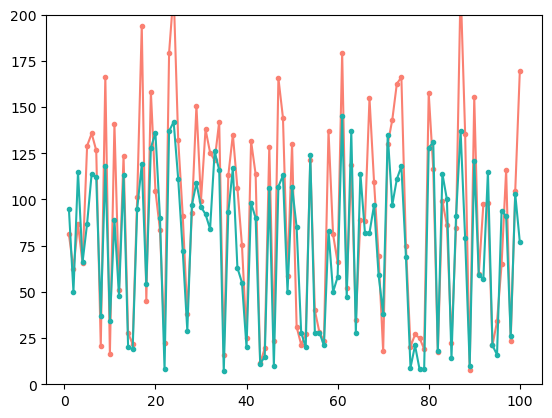

In [32]:
# fig, ax = plt.subplots( figsize = (14,8))
# plt.subplot(1,2,1)
plt.plot(np.arange(1,101), y_pred.cpu().numpy(), label = 'predictions', c = 'salmon', marker = '.')
ax1 = plt.gca()
ax1.set_ylim([0, 200])


plt.plot(np.arange(1,101), y.cpu().numpy(), label = 'true values', c = 'lightseagreen', marker = '.')
ax2 = plt.gca()
ax2.set_ylim([0, 200])

# # plt.set_xlabel('Test Engine Units', fontsize = 16)
# # plt.set_ylabel('RUL', fontsize = 16)
# ax.grid(True)
# ax.legend()
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

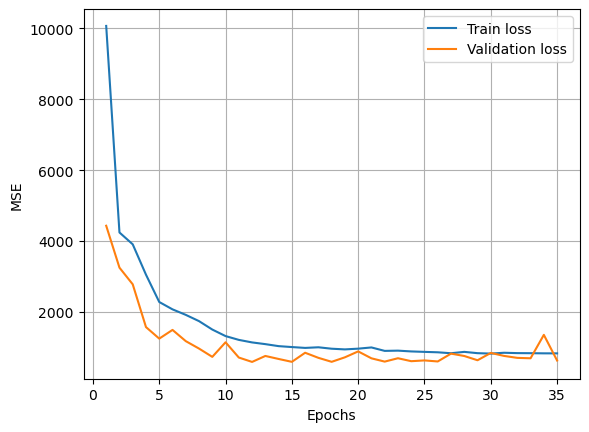

In [33]:
plt.plot(np.arange(1,len(T)+1), T, label= 'Train loss')
plt.plot(np.arange(1,len(V)+1), V, label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show

In [34]:
fig, ax = plt.subplots(figsize = (12,8))

def animate(i):
    ax.clear()
    line1, = ax.plot(np.arange(1,i+1), T[:i], label = 'train_loss')
    line2, = ax.plot(np.arange(1,i+1), V[:i], label = 'val_loss')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,101)
    ax.set_ylim(0,4000)
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE')
                     
    return line1, line2
                     
    
animation = FA(fig, animate, np.arange(1,len(T)+1), interval = 50)

%time animation.save('animation3.gif', writer='imagemagick', fps=20)

plt.close(fig)

MovieWriter imagemagick unavailable; using Pillow instead.


CPU times: total: 3.53 s
Wall time: 3.55 s


![](./animation3.gif)

## 3. Prediction on Test Set ##

In [35]:
model_save_dir = "model"
model_load_path = os.path.join(model_save_dir, 'LSTM_FD001_model.pth')
# Re-initialize model architecture before loading state_dict
model_loaded = LSTMRegressor(n_features, n_hidden_units).to(device)
model_loaded.load_state_dict(torch.load(model_load_path))
model_loaded.eval() # Set to evaluation mode

LSTMRegressor(
  (lstm): LSTM(16, 12, batch_first=True)
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=12, out_features=12, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=12, out_features=1, bias=True)
)

In [36]:
1*(y_pred < y)

tensor([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 0], device='cuda:0')

In [37]:
torch.dot(y - y_pred, 1.0*(y_pred<y)).item()/len(y)

3.657195739746094

In [38]:
torch.sum(torch.abs(y-y_pred)).item()/len(y)

22.08828125

In [39]:
## Checking what percentage of the predictions are higher than the true values
(y<y_pred).count_nonzero().item()/len(y)


0.74

## 4. Explaining Results Using SHAP and TimeSHAP

In [40]:
import shap
from timeshap import explainer
from timeshap.plot import plot_global_feat
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm

IPython could not be loaded!


In [41]:
model_loaded.eval()
test_iterator = iter(testloader)
test_windows_tensor, test_true_rul_tensor = next(test_iterator)

test_windows_sequential = test_windows_tensor.cpu().numpy() #Shape: (100, window, n_features)
test_true_rul = test_true_rul_tensor.cpu().numpy()
print(f"Foreground data shape (sequential): {test_windows_sequential.shape}")

#Extract Background Data (Sampled Training Windows)
print("Extracting background (training) data...")
n_background_samples = 100 #
background_windows_list = []
num_batches_needed = (n_background_samples + trainloader.batch_size - 1) // trainloader.batch_size

count = 0
train_iterator = iter(trainloader)
for _ in range(num_batches_needed):
    try:
        X_batch, _ = next(train_iterator)
        samples_to_take = min(n_background_samples - count, X_batch.shape[0])
        background_windows_list.append(X_batch.cpu().numpy()[:samples_to_take, :, :])
        count += samples_to_take
        if count >= n_background_samples:
            break
    except StopIteration:
        print("Warning: Reached end of trainloader before getting desired background samples.")
        break

background_windows_sequential = np.concatenate(background_windows_list, axis=0)
print(f"Background data shape (sequential): {background_windows_sequential.shape}")

#Data Formats
print("Preparing flattened data formats...")
#Flattening for standard SHAP KernelExplainer
test_windows_flat = test_windows_sequential.reshape(test_windows_sequential.shape[0], -1)
background_windows_flat = background_windows_sequential.reshape(background_windows_sequential.shape[0], -1)
print(f"Foreground data shape (flattened): {test_windows_flat.shape}")
print(f"Background data shape (flattened): {background_windows_flat.shape}")


# We need to get the columns that were *not* dropped and are *not* unit/time/rul
original_cols = ['unit', 'time', 'os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21', 'rul']
# Dropped cols: 'os3','s1','s5','s6','s10','s16','s18','s19'

base_feature_names = [col for col in df_train.columns if col not in ['unit', 'time', 'rul']]
print(f"Base feature names: {base_feature_names}")

# Flattened Features for SHAP
flat_feature_names = [f"{name}_t{t}" for t in range(window) for name in base_feature_names]
print(f"Number of flattened feature names: {len(flat_feature_names)}")

Foreground data shape (sequential): (100, 20, 16)
Extracting background (training) data...
Background data shape (sequential): (100, 20, 16)
Preparing flattened data formats...
Foreground data shape (flattened): (100, 320)
Background data shape (flattened): (100, 320)
Base feature names: ['os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
Number of flattened feature names: 320


### Initializing SHAP Values

In [42]:
#Prediction Function Wrapper for KernelExplainer
def predict_fn_for_kernel(data_flat_np):
    n_samples = data_flat_np.shape[0]
    #Reshape from (n_samples, window * n_features) to (n_samples, window, n_features)
    data_sequential_np = data_flat_np.reshape(n_samples, window, n_features)

    data_tensor = torch.tensor(data_sequential_np, dtype=torch.float32).to(device)
    model_loaded.eval()
    with torch.no_grad():
        predictions = model_loaded(data_tensor)
    return predictions.cpu().numpy()

background_summary_flat = shap.kmeans(background_windows_flat, 20)

#Initializing KernelExplainer
explainer_kernel = shap.KernelExplainer(predict_fn_for_kernel, background_summary_flat)

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


### Computing SHAP Values

In [43]:
shap_values_kernel = explainer_kernel.shap_values(test_windows_flat, nsamples='auto')
print(f"SHAP values shape: {shap_values_kernel.shape}") #Should be (n_test_samples, window * n_features)

  0%|          | 0/100 [00:00<?, ?it/s]

SHAP values shape: (100, 320)


### Saving SHAP Values

In [49]:
import numpy as np
import os

results_dir = "shap-values"

shap_values_filename = os.path.join(results_dir, "shap_values_kernel_fd001.npy")

try:
    np.save(shap_values_filename, shap_values_kernel)
    print(f"SHAP values successfully saved to: {shap_values_filename}")
except Exception as e:
    print(f"Error saving SHAP values: {e}")

SHAP values successfully saved to: shap-values\shap_values_kernel_fd001.npy


### Loading SHAP

In [49]:
import numpy as np
import os

results_dir = "shap-values"
shap_values_filename = os.path.join(results_dir, "shap_values_kernel_fd001.npy")

try:
    shap_values_kernel = np.load(shap_values_filename)

    print(f"Loaded SHAP values shape: {shap_values_kernel.shape}") #Should be (100, 320)
    print(f"Data type: {shap_values_kernel.dtype}") #float

except FileNotFoundError:
    print(f"ERROR: File not found at {shap_values_filename}")
    print("Please ensure the file exists in the correct directory or re-run the SHAP calculation.")
    #Set variable to None or raise error to prevent plotting issues
    shap_values_kernel = None
except Exception as e:
    print(f"Error loading SHAP values: {e}")
    shap_values_kernel = None

Attempting to load SHAP values from: shap-values\shap_values_kernel_fd001.npy
SHAP values successfully loaded.
Loaded SHAP values shape: (100, 320)
Data type: float64


### Computing TimeSHAP Values

In [44]:
import timeshap.explainer as tsx
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd

#Prediction Function Wrapper
def predict_fn_for_timeshap(seq_batch_np: np.ndarray) -> np.ndarray:
    try:
        batch_tensor = torch.tensor(seq_batch_np, dtype=torch.float32, device=device)
        model_loaded.eval()
        with torch.no_grad():
            out_tensor = model_loaded(batch_tensor)
        out_np = out_tensor.cpu().numpy()
        return out_np.reshape(-1, 1) #Ensures (n, 1) output
    except Exception as e:
        print(f"ERROR inside predict_fn_for_timeshap: {e}")
        raise e

f_dict = {name: i for i, name in enumerate(base_feature_names)}
print(f"Feature dictionary created.")

baseline_seq = None #Initializing
if 'background_windows_sequential' in locals() and background_windows_sequential is not None and background_windows_sequential.ndim == 3:
    try:
        #Calculate mean sequence across samples -> shape (window, n_features)
        baseline_seq = background_windows_sequential.mean(axis=0)

        print(f"Using sequence baseline with shape: {baseline_seq.shape}")
        #Verification check
        expected_shape = (window, n_features)
        assert baseline_seq.shape == expected_shape, \
            f"Baseline sequence shape error! Expected {expected_shape}, Got {baseline_seq.shape}"
        print("Sequence baseline created successfully.")
    except Exception as base_err:
       print(f"ERROR creating sequence baseline: {base_err}")
       baseline_seq = None
else:
    print("ERROR: Valid 3D background_windows_sequential not found.")
    baseline_seq = None

explainer_timeshap = None
if baseline_seq is not None:
    try:
        all_event_indices = list(range(window))      #0 to 19
        all_feature_indices = list(range(n_features)) #0 to 15
        varying_param = (all_event_indices, all_feature_indices)

        explainer_timeshap = tsx.TimeShapKernel(
            predict_fn_for_timeshap,
            baseline_seq,
            SEED,
            "cell",
            varying=varying_param
        )
        print("TimeSHAP Explainer initialized successfully (mode='cell').")

    except Exception as init_err:
        print(f"ERROR initializing TimeSHAP Explainer: {init_err}")
        explainer_timeshap = None
else:
     print("Skipping TimeSHAP initialization due to baseline error.")


#Computing TimeSHAP values
ts_shap_vals = None
computation_successful = False

if explainer_timeshap is not None:
    print("\nComputing TimeSHAP explanations (mode='cell') by looping...")
    try:
        n_test_samples = test_windows_sequential.shape[0]
        nsamples_ts = 256
        pruning_index = 0
        print(f"Using nsamples={nsamples_ts} and pruning_idx={pruning_index} for each sequence.")

        ts_shap_vals = np.empty((n_test_samples, window, n_features), dtype=np.float32)

        for i in range(n_test_samples):
            seq = test_windows_sequential[i] #Shape: (window, n_features)
            seq_batch = seq[None, ...] #Shape: (1, window, n_features)

            #Explaining the single sequence
            Z = explainer_timeshap.shap_values(
                    seq_batch,
                    pruning_idx=pruning_index,
                    nsamples=nsamples_ts
                ) #Expected return: Flattened vector (window * n_features,)

            if Z is None:
                raise RuntimeError(f"TimeSHAP returned None for sequence index {i}.")

            if Z.ndim == 2 and Z.shape[0] == 1:
                Z = Z.squeeze(0) # -> (flat_len,)

            expected_flat_len = window * n_features
            if Z.ndim == 1 and Z.shape[0] == expected_flat_len:
                Z = Z.reshape(window, n_features) #(window, n_features) (20, 16)

            expected_z_shape = (window, n_features)
            if Z.shape != expected_z_shape:
                 raise ValueError(f"Unexpected shape {Z.shape} after reshape for index {i}. Expected {expected_z_shape}.")

            #Store the correctly shaped (window, n_features) array
            ts_shap_vals[i] = Z

        print(f"\n✓ TimeSHAP completed for all {n_test_samples} sequences.")
        print(f"  Final TimeSHAP values tensor shape: {ts_shap_vals.shape}") #Should be (100, 20, 16)
        computation_successful = True

    except Exception as explain_err:
        print(f"ERROR computing TimeSHAP values during loop: {explain_err}")
        ts_shap_vals = None
        computation_successful = False
else:
    print("\nSkipping TimeSHAP computation due to previous error.")

Feature dictionary created.
Using sequence baseline with shape: (20, 16)
Sequence baseline created successfully.
TimeSHAP Explainer initialized successfully (mode='cell').

Computing TimeSHAP explanations (mode='cell') by looping...
Using nsamples=256 and pruning_idx=0 for each sequence.

✓ TimeSHAP completed for all 100 sequences.
  Final TimeSHAP values tensor shape: (100, 20, 16)


### Plotting SHAP Results

Using base value for waterfall plots: 88.5687

Generating Waterfall plots for Engines: [1, 10, 25, 50]...
  Plotting for Engine 1 (Index 0)...
    Waterfall plot saved to plots\shap_feature_contribution_engine_1.png


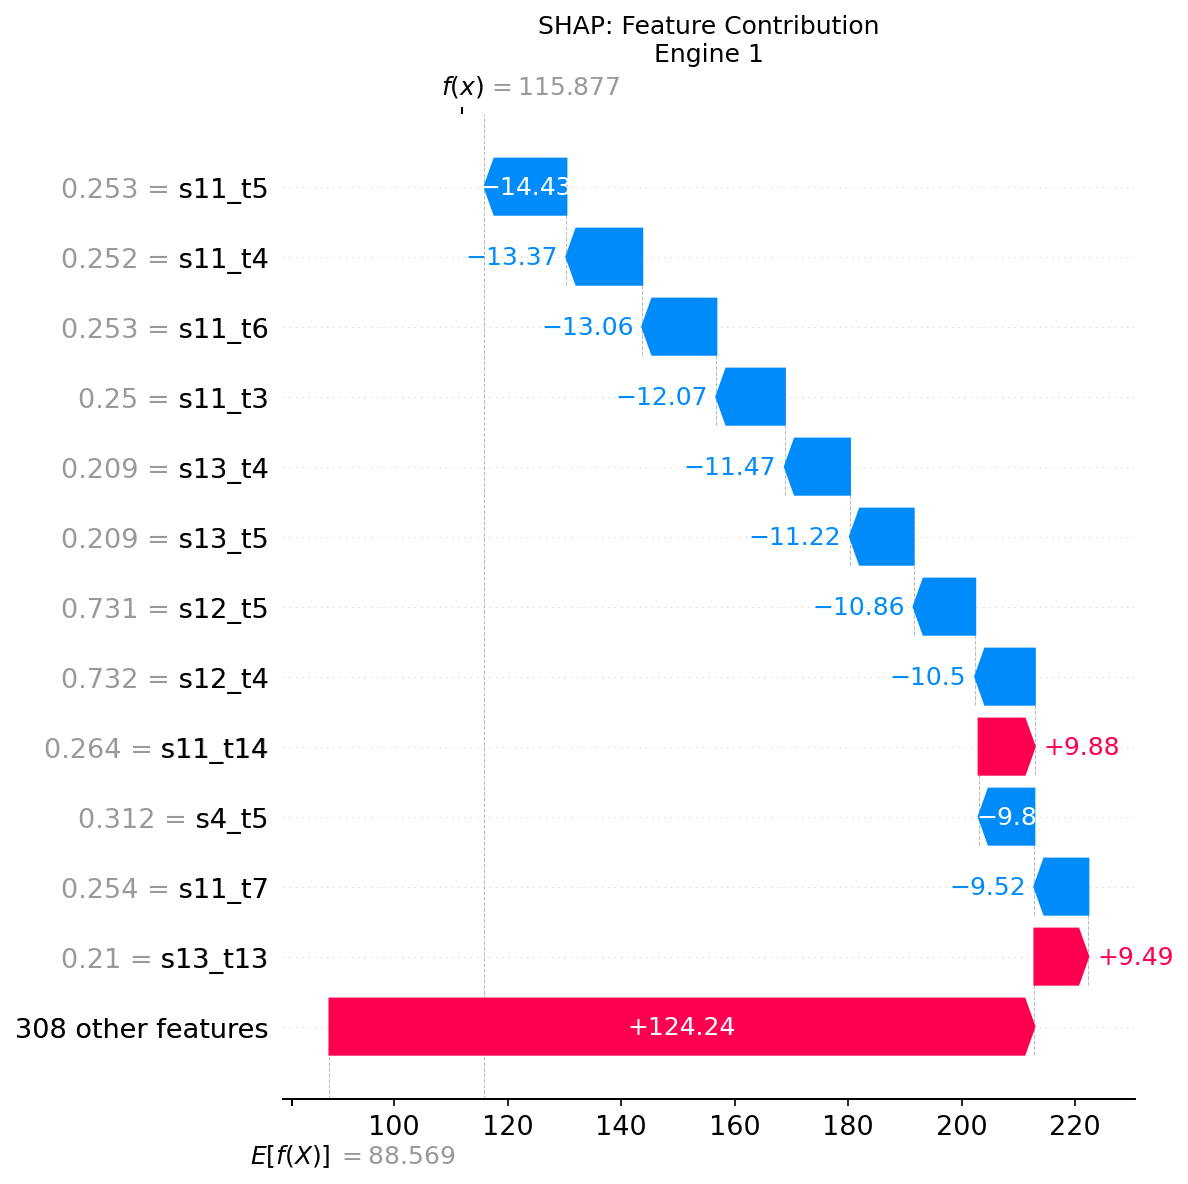

  Plotting for Engine 10 (Index 9)...
    Waterfall plot saved to plots\shap_feature_contribution_engine_10.png


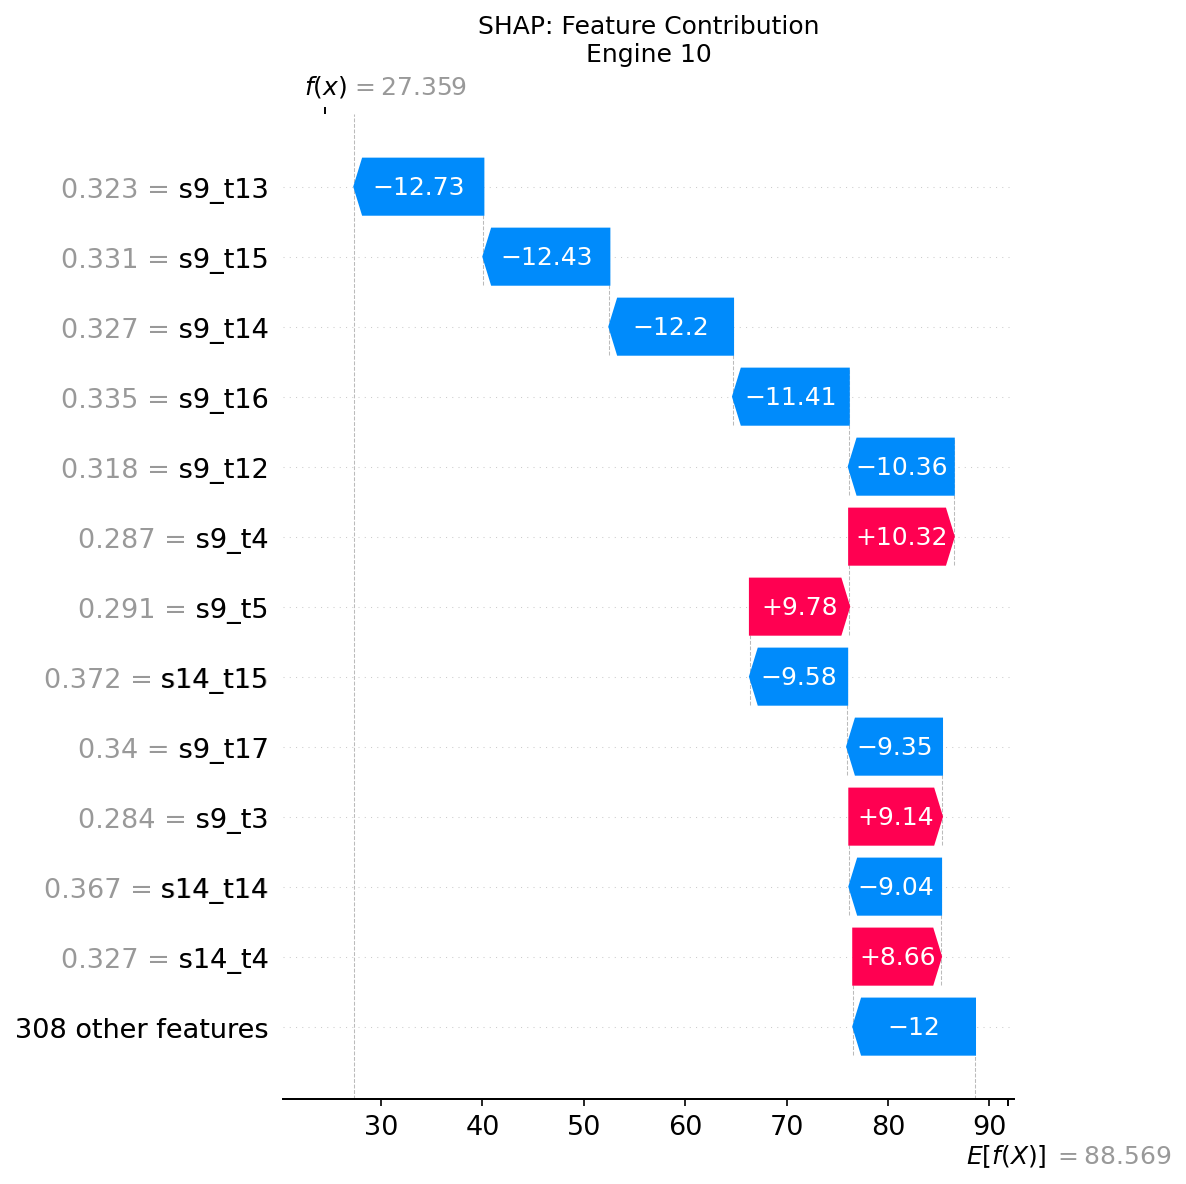

  Plotting for Engine 25 (Index 24)...
    Waterfall plot saved to plots\shap_feature_contribution_engine_25.png


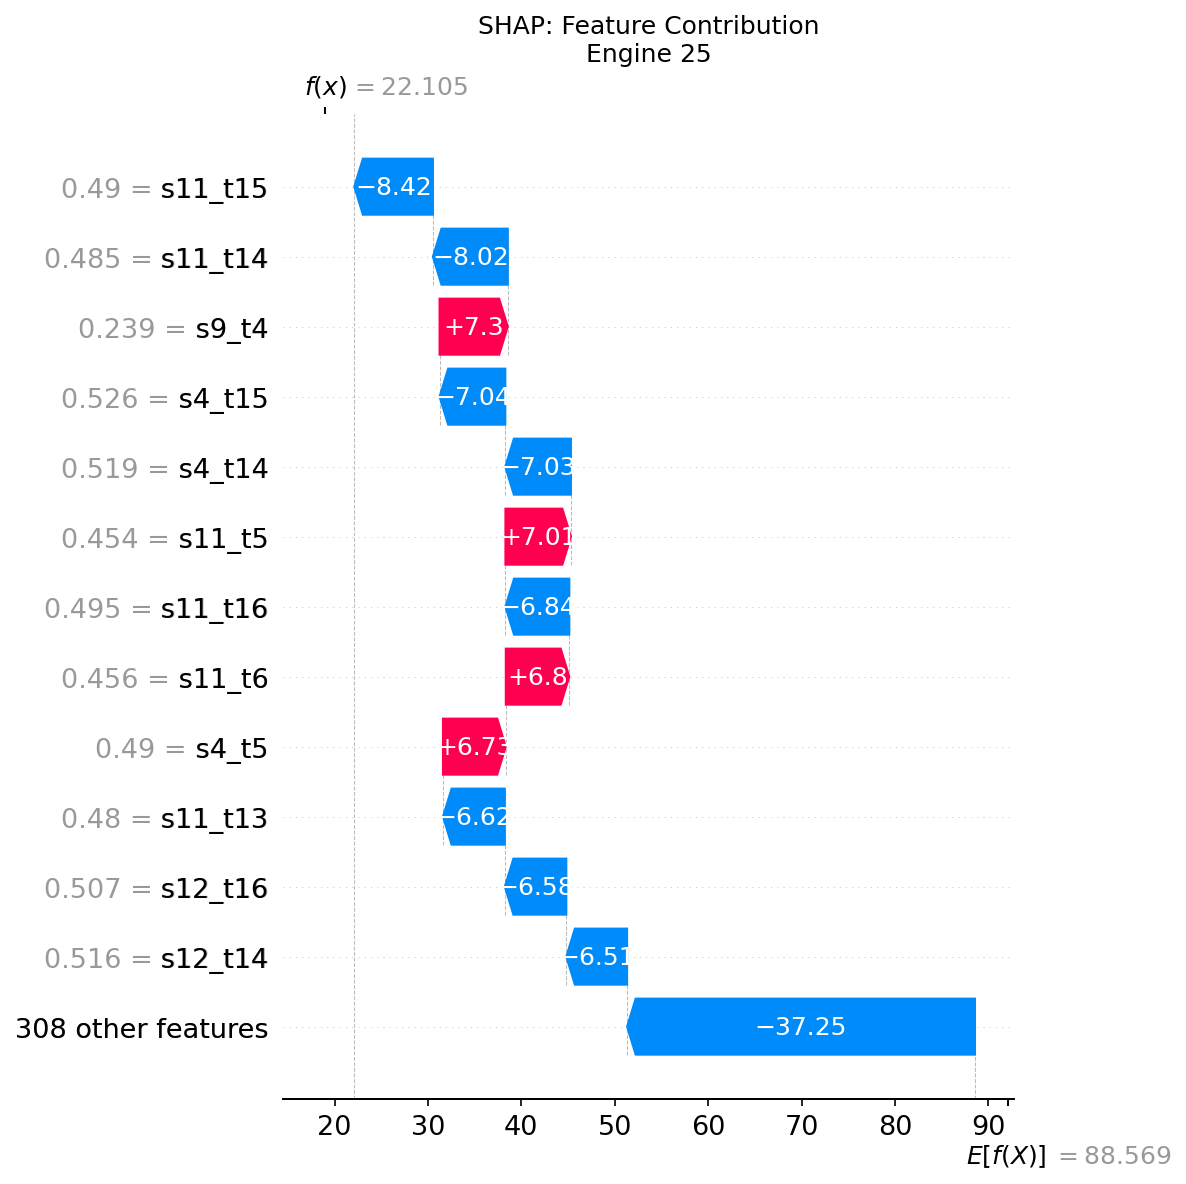

  Plotting for Engine 50 (Index 49)...
    Waterfall plot saved to plots\shap_feature_contribution_engine_50.png


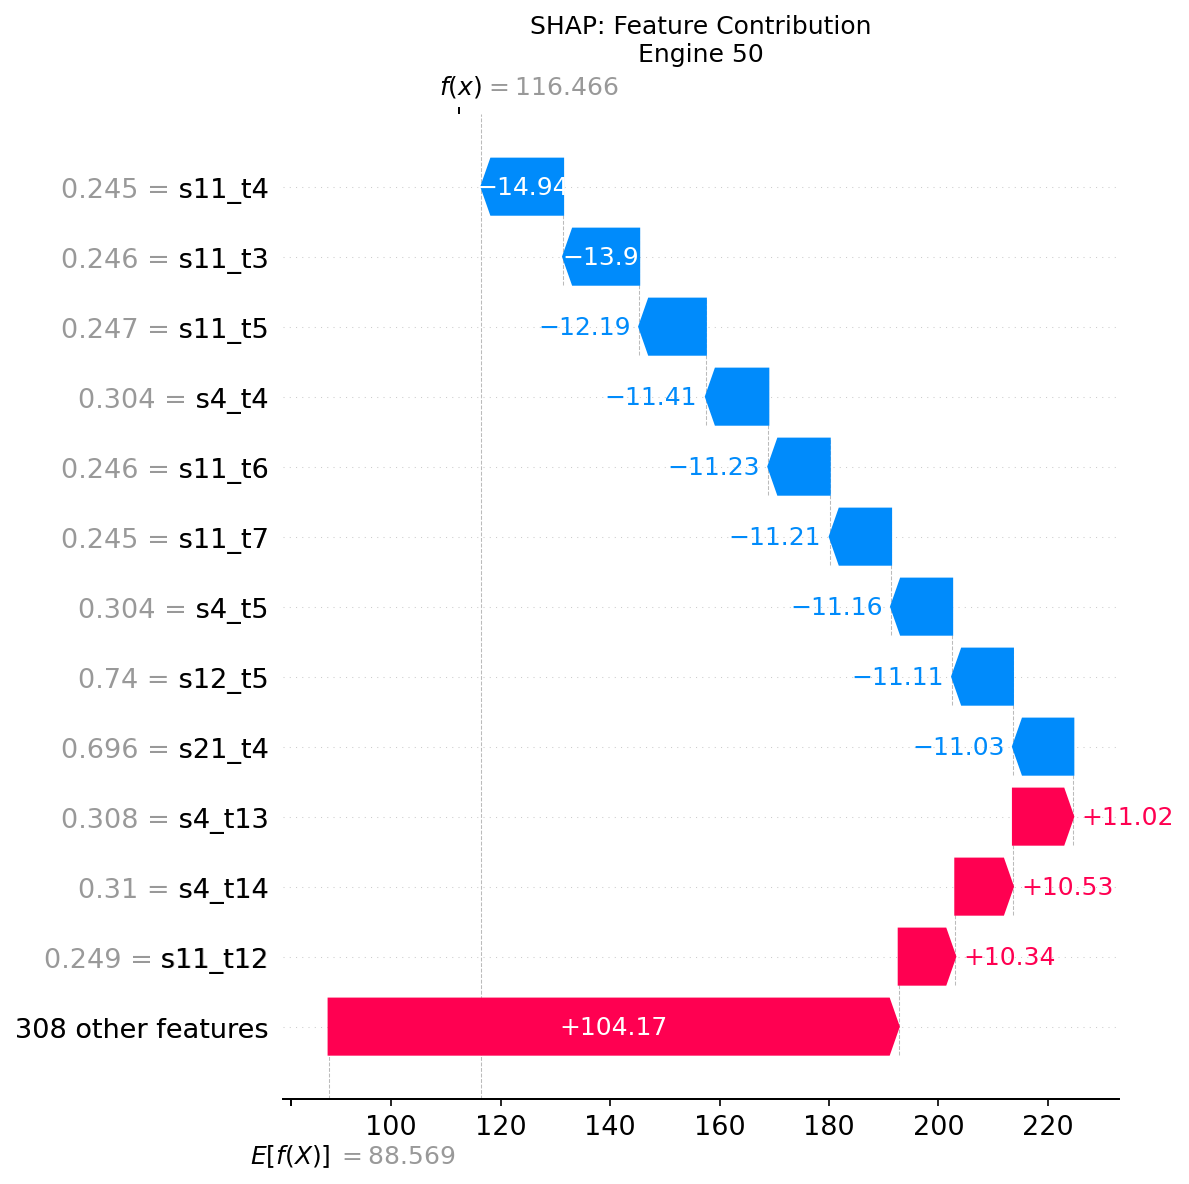


Generating Summary plot (Top 12 features, no color bar)...


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Summary plot saved to plots\shap_values_distribution.png


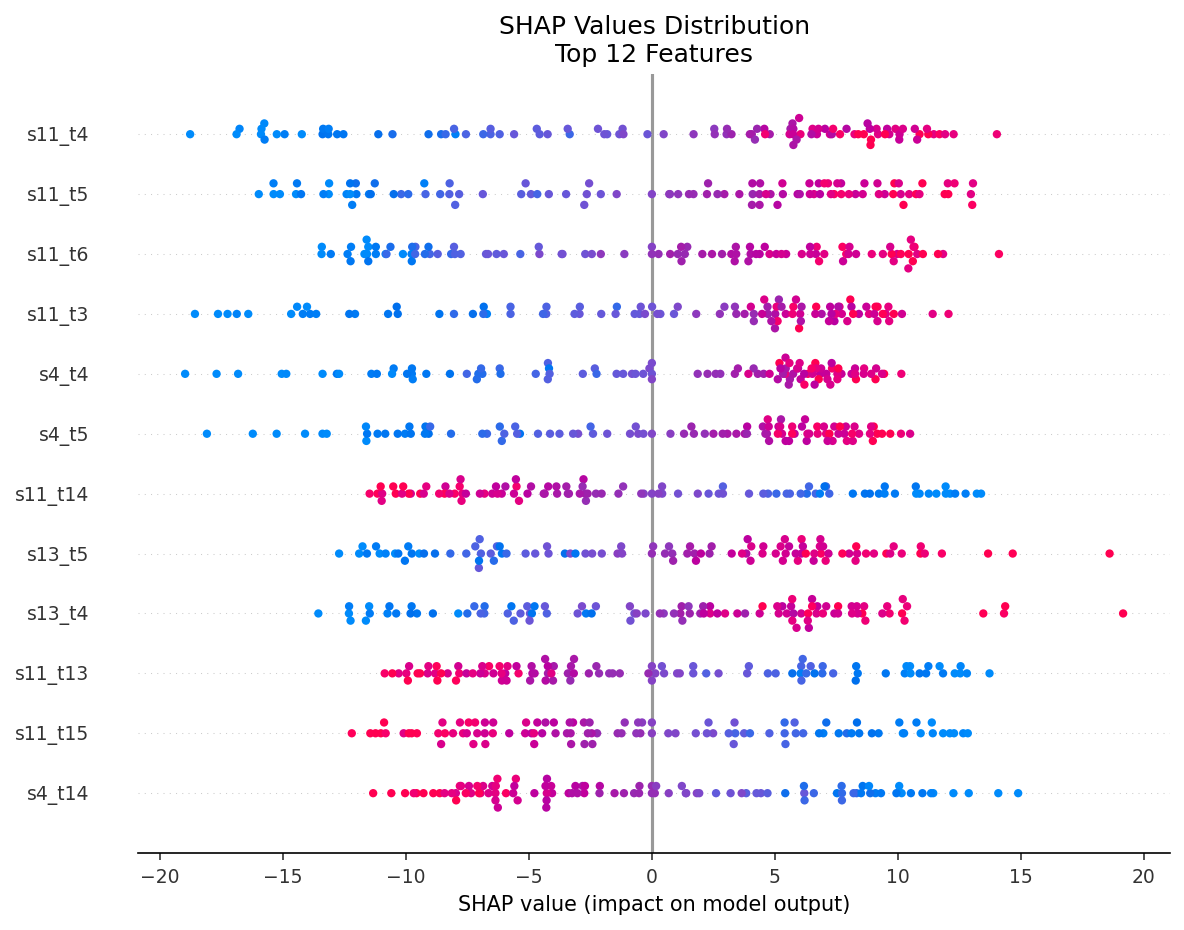


Generating Manual Color Bar figure...
Generic Color Bar saved to plots\shap_colorbar.png


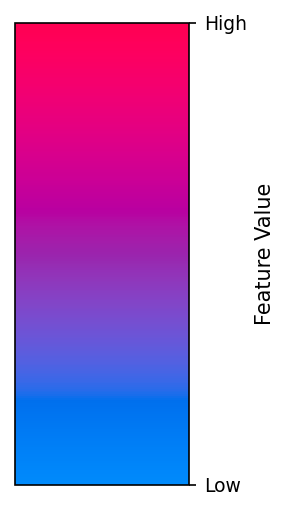

In [51]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import os

figure_dpi = 150
plot_figsize = (8, 6)
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 9
plots_save_dir = "plots"
os.makedirs(plots_save_dir, exist_ok=True)

variables_to_check = {
    'shap_values_kernel': ('(100, 320) numpy array', (100, window * n_features)),
    'explainer_kernel': ('shap.KernelExplainer object', None),
    'test_windows_flat': ('(100, 320) numpy array', (100, window * n_features)),
    'flat_feature_names': ('list of 320 strings', 320)
}
plots_possible = True
for var_name, (desc, expected_shape) in variables_to_check.items():
    if var_name not in locals():
        print(f"ERROR: Variable '{var_name}' ({desc}) not found. Cannot create plots.")
        plots_possible = False
    elif expected_shape is not None:
         # Check shape for numpy arrays, length for lists
         current_shape = getattr(locals()[var_name], 'shape', None)
         if current_shape is None and isinstance(locals()[var_name], list):
              current_shape = len(locals()[var_name])
              expected_shape = expected_shape # Use the integer length expected

         if current_shape != expected_shape:
             print(f"ERROR: Variable '{var_name}' has wrong shape/length. Expected {expected_shape}, got {current_shape}.")
             plots_possible = False

if plots_possible and not hasattr(explainer_kernel, 'expected_value'):
     print("ERROR: explainer_kernel does not have expected_value attribute. Waterfall plots cannot be generated.")

     plots_possible = False
elif plots_possible:
     base_value = explainer_kernel.expected_value
     if isinstance(base_value, (list, np.ndarray)) and len(base_value) == 1:
         base_value = base_value[0]
     print(f"Using base value for waterfall plots: {base_value:.4f}")


if plots_possible:
   #Waterfall Plots for Specific Engines (Top 12 Features) ---
    engine_indices_to_plot = [0, 9, 24, 49] #Corresponds to Engine 1, 10, 25, 50
    engine_ids = [idx + 1 for idx in engine_indices_to_plot]
    max_display_waterfall = 13 #Shows top 12 + "others" bar

    print(f"\nGenerating Waterfall plots for Engines: {engine_ids}...")

    for i, engine_idx in enumerate(engine_indices_to_plot):
        engine_id_actual = engine_ids[i]
        print(f"  Plotting for Engine {engine_id_actual} (Index {engine_idx})...")
        fig_wf = None
        try:
            #Create SHAP Explanation object for the specific instance
            exp = shap.Explanation(
                values=shap_values_kernel[engine_idx, :],
                base_values=base_value,
                data=test_windows_flat[engine_idx, :],
                feature_names=flat_feature_names
            )

            fig_wf, ax_wf = plt.subplots(figsize=plot_figsize, dpi=figure_dpi)
            shap.plots.waterfall(exp, max_display=max_display_waterfall, show=False)

            xmin, xmax = ax_wf.get_xlim()
            padding = (xmax - xmin) * 0.05
            ax_wf.set_xlim(xmin - padding, xmax + padding)

            plt.title(f"SHAP: Feature Contribution\nEngine {engine_id_actual}", fontsize=title_fontsize)
            plt.tight_layout()

            wf_filename = os.path.join(plots_save_dir, f"shap_feature_contribution_engine_{engine_id_actual}.png")
            plt.savefig(wf_filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"    Waterfall plot saved to {wf_filename}")
            plt.show()
            plt.close(fig_wf)

        except Exception as e:
            print(f"    Error generating waterfall plot for Engine {engine_id_actual}: {e}")
            if fig_wf is not None:
                 plt.close(fig_wf)

    #Summary Plot
    print("\nGenerating Summary plot (Top 12 features, no color bar)...")
    max_display_summary = 12
    try:
        fig_dot_final, ax_dot_final = plt.subplots(figsize=plot_figsize, dpi=figure_dpi)
        shap.summary_plot(
            shap_values_kernel,
            features=test_windows_flat,
            feature_names=flat_feature_names,
            max_display=max_display_summary,
            color_bar=False, #False due to errors with the library
            show=False
        )

        current_ax = plt.gca()
        current_ax.spines['top'].set_visible(False)
        current_ax.spines['right'].set_visible(False)
        current_ax.tick_params(axis='x', labelsize=tick_fontsize)
        current_ax.tick_params(axis='y', labelsize=tick_fontsize)
        plt.title(f"SHAP Values Distribution\nTop {max_display_summary} Features", fontsize=title_fontsize)
        current_ax.xaxis.label.set_size(label_fontsize)
        plt.tight_layout()

        dot_filename = os.path.join(plots_save_dir, f"shap_values_distribution.png")
        plt.savefig(dot_filename, dpi=figure_dpi, bbox_inches='tight')
        print(f"Summary plot saved to {dot_filename}")
        plt.show()
        plt.close(fig_dot_final)

    except Exception as e:
        print(f"Error generating Summary plot: {e}")
        if 'fig_dot_final' in locals(): plt.close(fig_dot_final)


    #Manual Generic Color Bar
    #Note: This shows the color mapping concept but isn't directly linked
    #to the actual coloring data of the dot plot above (which was disabled due to library issues).
    print("\nGenerating Manual Color Bar figure...")
    try:
        fig_cbar, ax_cbar = plt.subplots(figsize=(1.5, 4), dpi=figure_dpi) # Small figure just for cbar

        #Trying to use SHAP's default red/blue colormap if available
        try:
            import shap.plots.colors
            cmap = shap.plots.colors.red_blue
        except (ImportError, AttributeError):
            cmap = plt.get_cmap('coolwarm')

        norm = colors.Normalize(vmin=0, vmax=1)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = fig_cbar.colorbar(sm, cax=ax_cbar, ticks=[0, 1], aspect=30)
        cbar.set_ticklabels(["Low", "High"])
        cbar.set_label("Feature Value", size=label_fontsize)
        cbar.ax.tick_params(labelsize=tick_fontsize)

        cbar_filename = os.path.join(plots_save_dir, "shap_colorbar.png")
        fig_cbar.savefig(cbar_filename, dpi=figure_dpi, bbox_inches='tight')
        print(f"Generic Color Bar saved to {cbar_filename}")
        plt.show()
        plt.close(fig_cbar)

    except Exception as e:
        print(f"Error generating manual color bar: {e}")
        if 'fig_cbar' in locals(): plt.close(fig_cbar)


else:
    print("\nSkipping Final SHAP Plots due to missing variables.")


--- Phase 4: Generating Combined 2x2 Waterfall Plots ---
Using base value for waterfall plots: 88.5687

Generating combined Waterfall plots for Engines: [1, 10, 25, 50]...
  Plotting for Engine 1 (on subplot 1)...
  Plotting for Engine 10 (on subplot 2)...
  Plotting for Engine 25 (on subplot 3)...
  Plotting for Engine 50 (on subplot 4)...

Combined waterfall plot saved to plots\shap_feature_contribution_combined.png


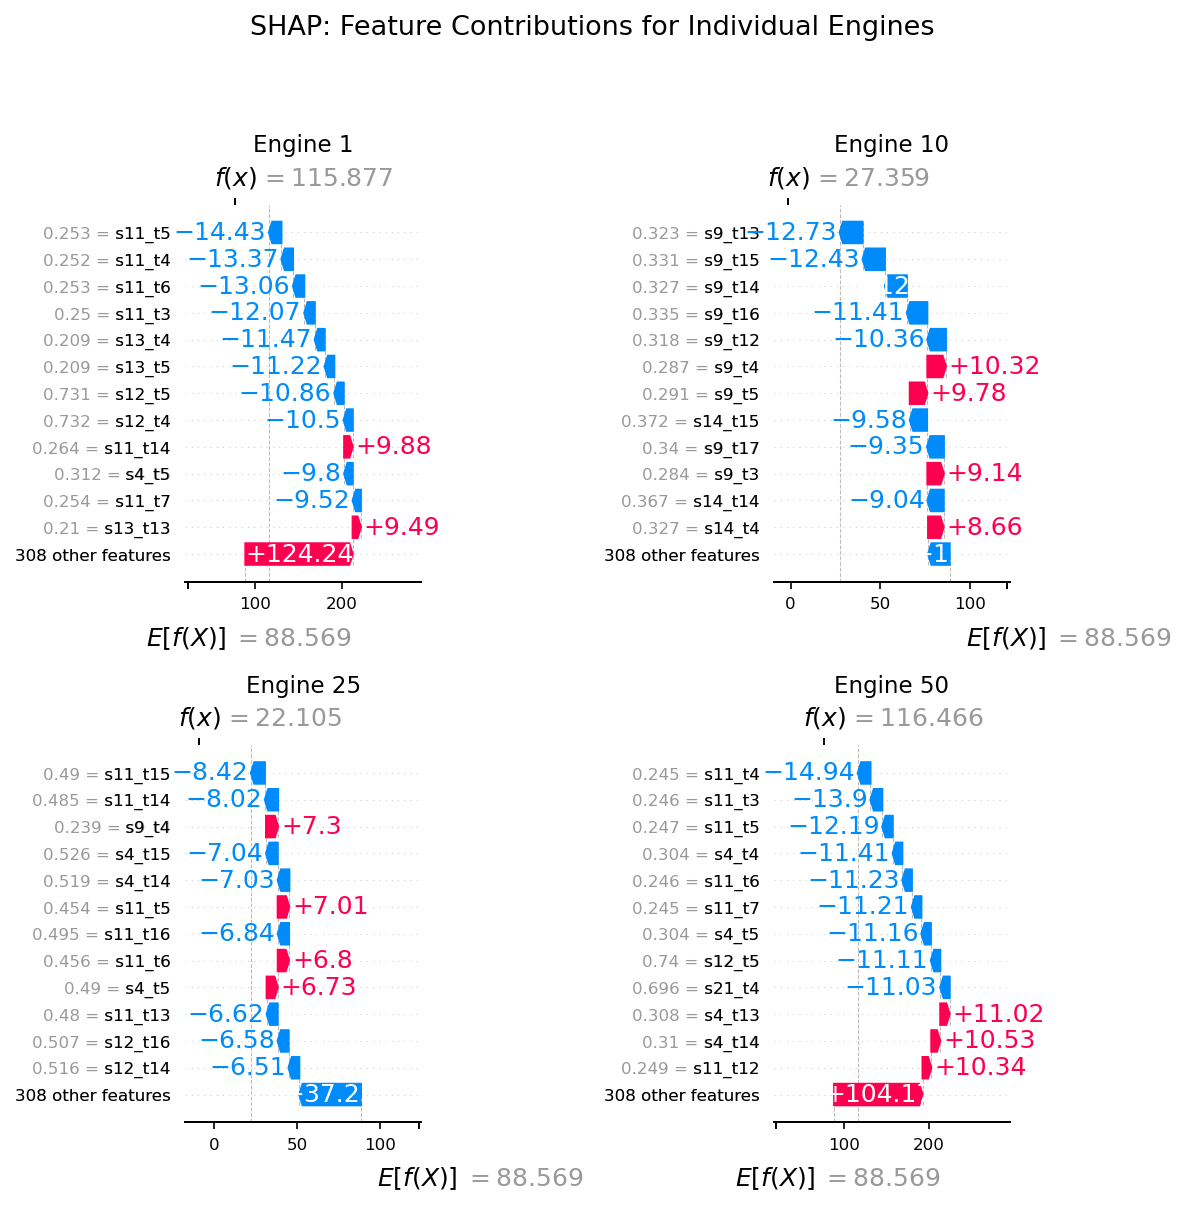

In [52]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

print("\n--- Phase 4: Generating Combined 2x2 Waterfall Plots ---")

figure_dpi = 150
combined_wf_figsize = (15, 10)
title_fontsize = 11
label_fontsize = 9
tick_fontsize = 8
max_display_waterfall = 13
plots_save_dir = "plots"

plots_possible = True
if 'shap_values_kernel' not in locals() or 'explainer_kernel' not in locals() or not hasattr(explainer_kernel, 'expected_value'):
     print("ERROR: Necessary SHAP data or explainer missing. Skipping plot.")
     plots_possible = False
elif plots_possible:
     # Extract base value safely
     base_value = explainer_kernel.expected_value
     if isinstance(base_value, (list, np.ndarray)) and len(base_value) == 1:
         base_value = base_value[0]
     print(f"Using base value for waterfall plots: {base_value:.4f}")


if plots_possible:
    fig_wf_combined, axes = plt.subplots(nrows=2, ncols=2, figsize=combined_wf_figsize, dpi=figure_dpi)
    axes_flat = axes.flatten()

    engine_indices_to_plot = [0, 9, 24, 49]
    engine_ids = [idx + 1 for idx in engine_indices_to_plot]

    print(f"\nGenerating combined Waterfall plots for Engines: {engine_ids}...")
    plot_successful = True
    try:
        for i, engine_idx in enumerate(engine_indices_to_plot):
            if i >= len(axes_flat): break

            ax = axes_flat[i]
            engine_id_actual = engine_ids[i]
            print(f"  Plotting for Engine {engine_id_actual} (on subplot {i+1})...")

            exp = shap.Explanation(
                values=shap_values_kernel[engine_idx, :],
                base_values=base_value,
                data=test_windows_flat[engine_idx, :],
                feature_names=flat_feature_names
            )

            plt.sca(ax)
            shap.plots.waterfall(exp, max_display=max_display_waterfall, show=False)


            ax.set_title(f"Engine {engine_id_actual}", fontsize=title_fontsize)

            xmin, xmax = ax.get_xlim()
            padding = (xmax - xmin) * 0.5
            ax.set_xlim(xmin - padding, xmax + padding)

            ax.tick_params(axis='both', labelsize=tick_fontsize)
            try:
                ax.xaxis.label.set_size(label_fontsize)
            except AttributeError: pass

    except Exception as e:
        print(f"    Error generating combined waterfall plot during loop: {e}")
        plot_successful = False

    if plot_successful:
        fig_wf_combined.suptitle("SHAP: Feature Contributions for Individual Engines", fontsize=title_fontsize + 2, y=1.0)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        wf_combined_filename = os.path.join(plots_save_dir, "shap_feature_contribution_combined.png")
        try:
            fig_wf_combined.savefig(wf_combined_filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"\nCombined waterfall plot saved to {wf_combined_filename}")
        except Exception as save_err:
            print(f"Error saving combined waterfall plot: {save_err}")

        plt.show()

    plt.close(fig_wf_combined)

### Plotting TimeSHAP Results


--- Generating plots for Engine 1 (Index 0) ---
  Generating Event Importance plot for Engine 1...
    Event plot saved to plots\timeshap_time_step_importance_engine_1.png


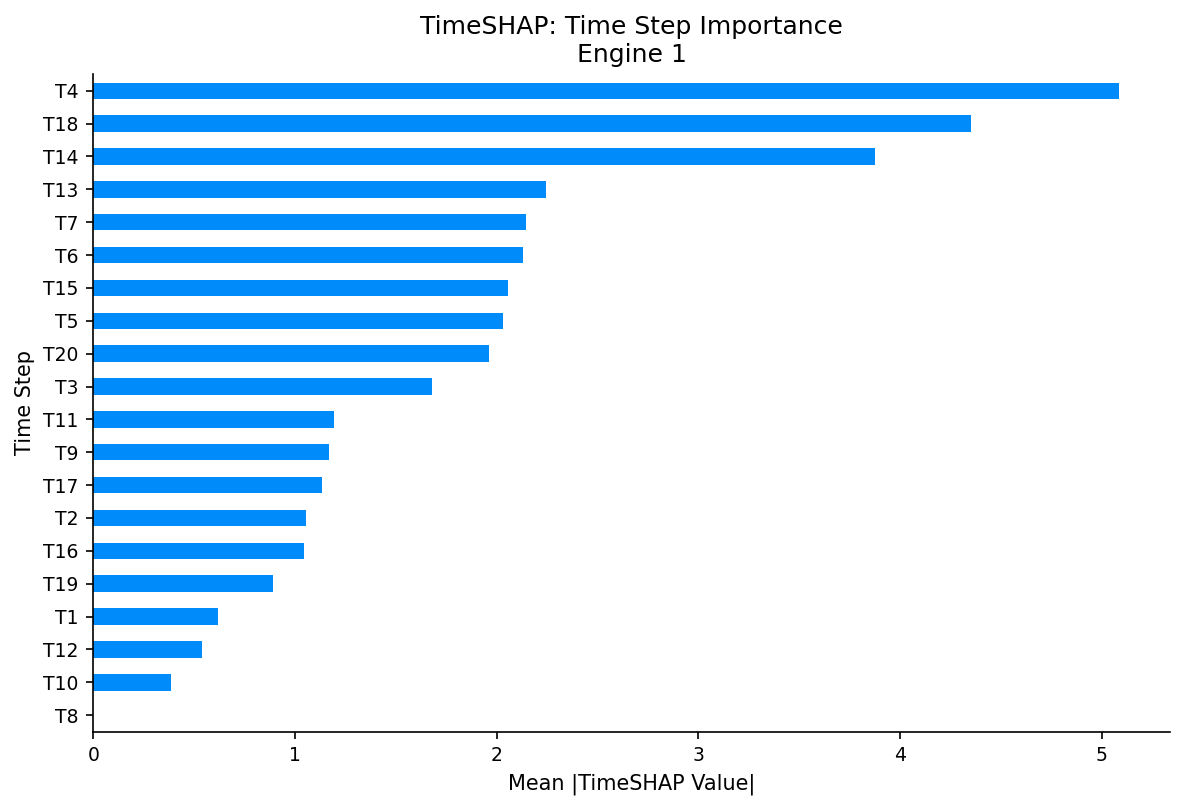

  Generating Cell Importance Heatmap for Engine 1...
    Heatmap saved to plots\timeshap_feature_contribution_heatmap_engine_1.png


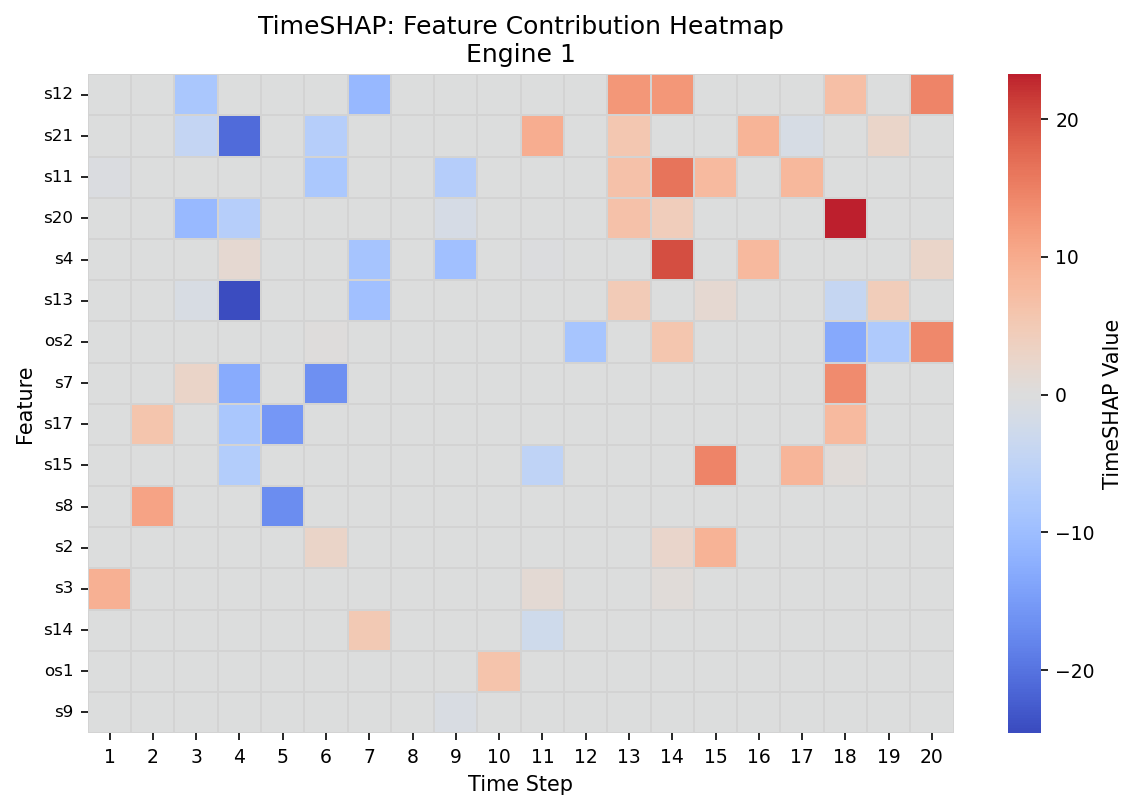


--- Generating plots for Engine 10 (Index 9) ---
  Generating Event Importance plot for Engine 10...
    Event plot saved to plots\timeshap_time_step_importance_engine_10.png


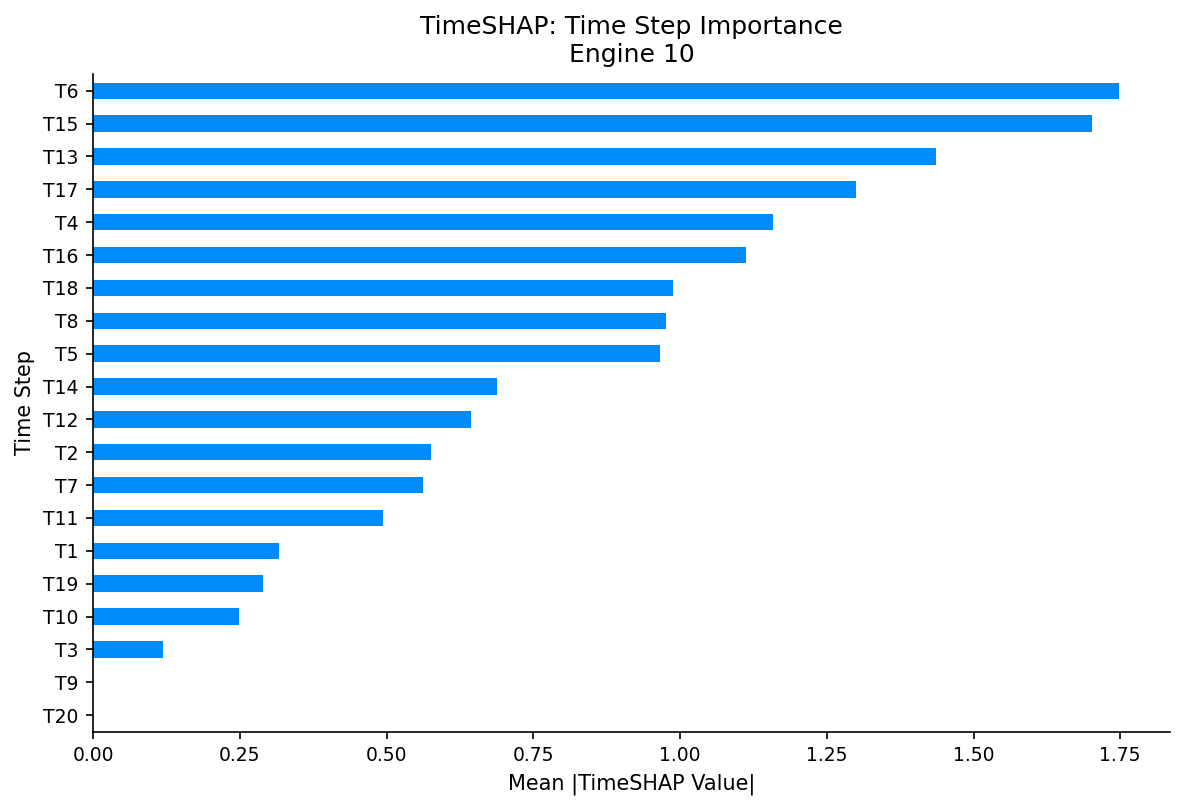

  Generating Cell Importance Heatmap for Engine 10...
    Heatmap saved to plots\timeshap_feature_contribution_heatmap_engine_10.png


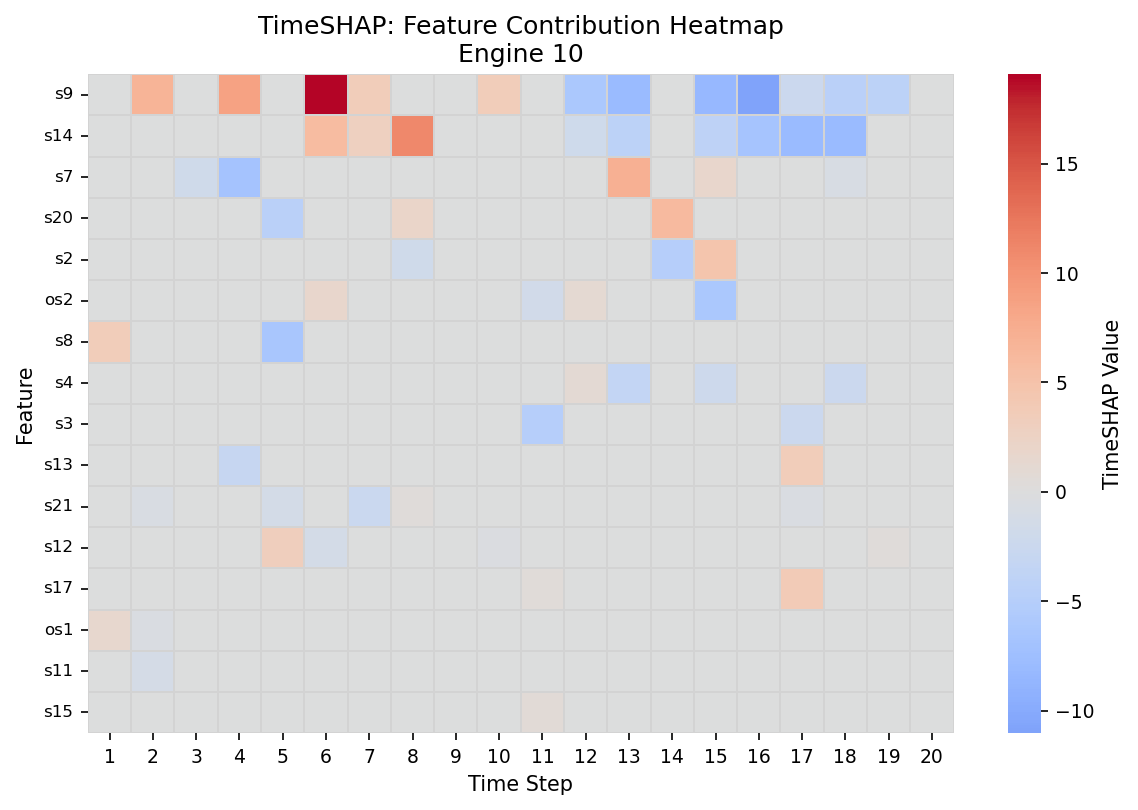


--- Generating plots for Engine 25 (Index 24) ---
  Generating Event Importance plot for Engine 25...
    Event plot saved to plots\timeshap_time_step_importance_engine_25.png


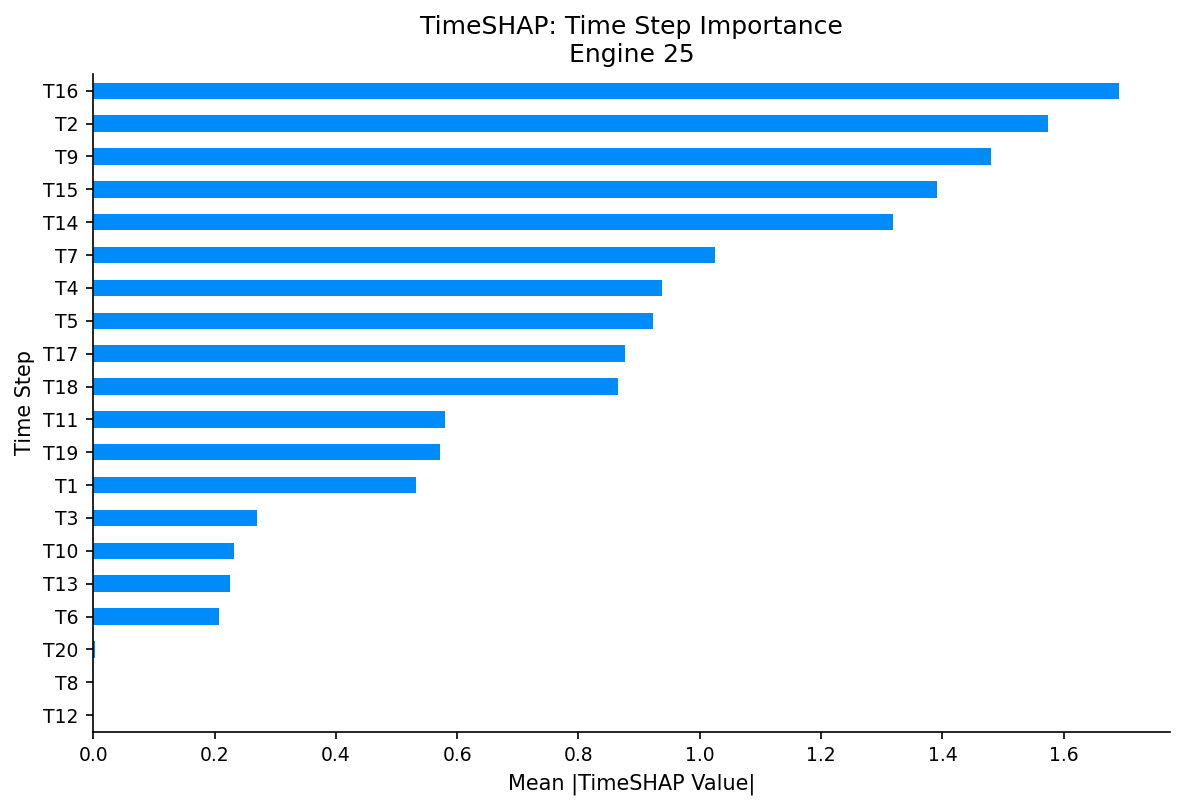

  Generating Cell Importance Heatmap for Engine 25...
    Heatmap saved to plots\timeshap_feature_contribution_heatmap_engine_25.png


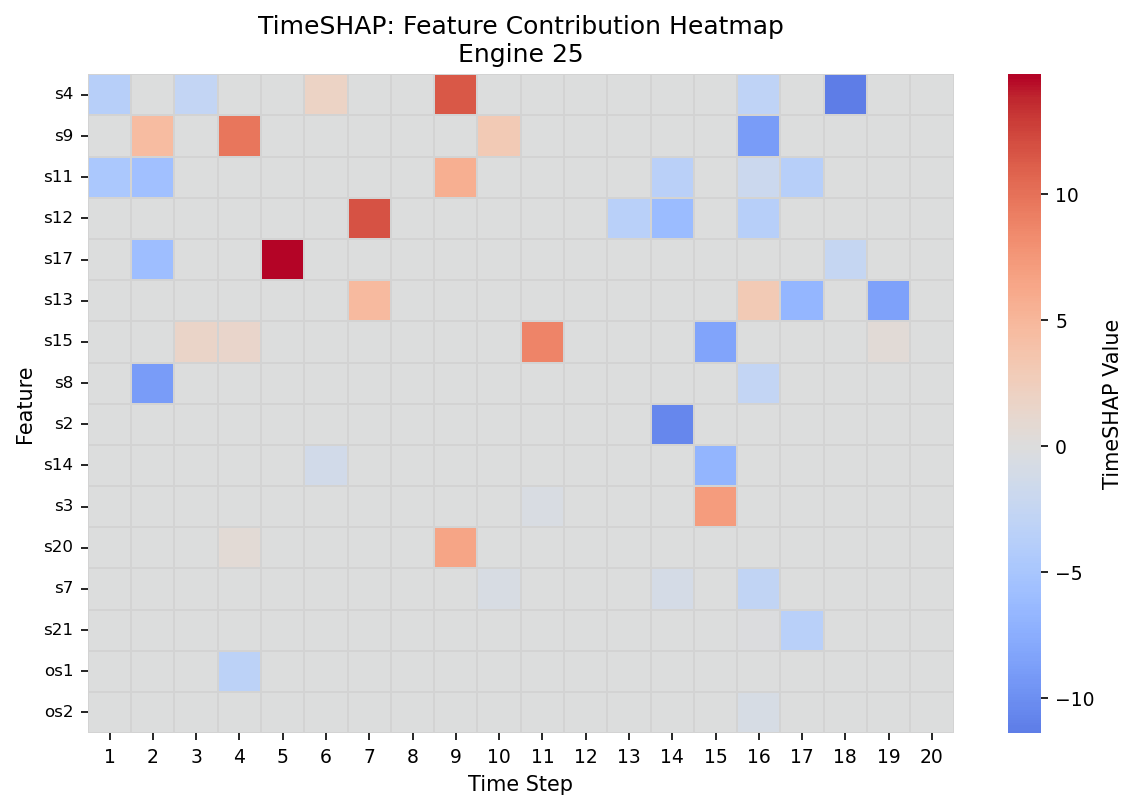


--- Generating plots for Engine 50 (Index 49) ---
  Generating Event Importance plot for Engine 50...
    Event plot saved to plots\timeshap_time_step_importance_engine_50.png


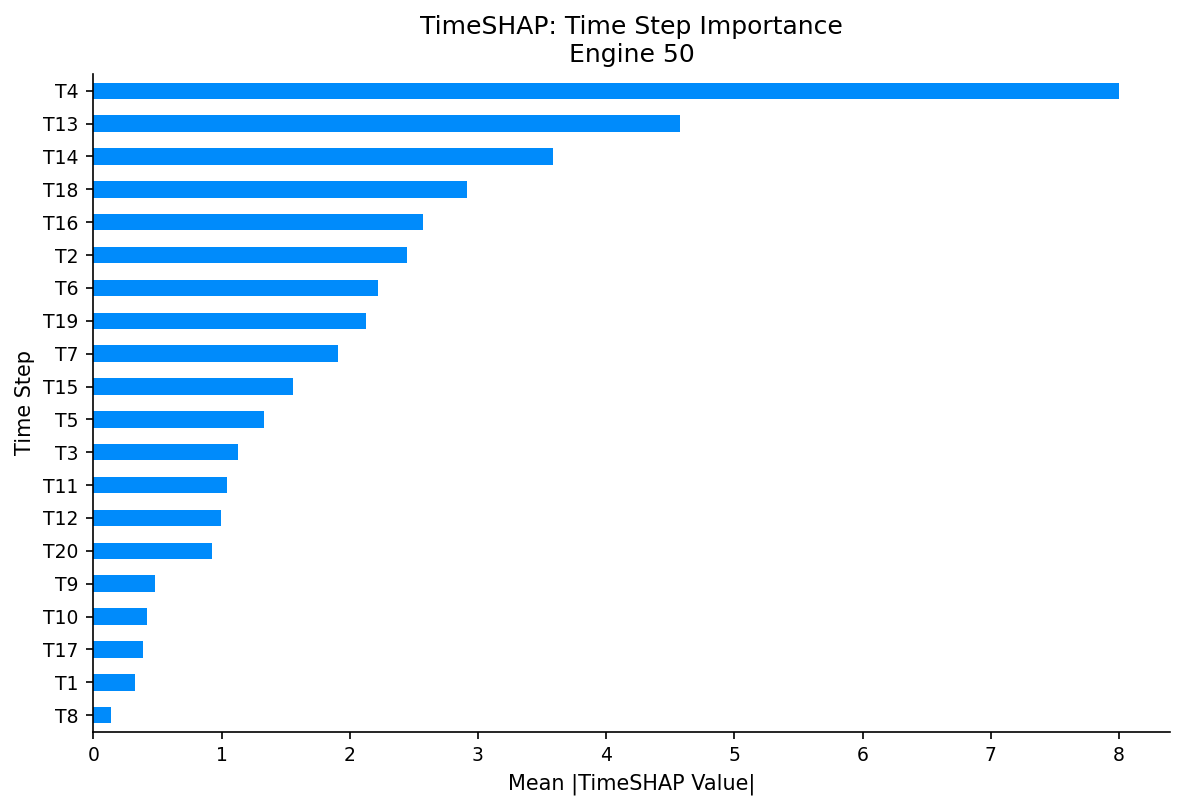

  Generating Cell Importance Heatmap for Engine 50...
    Heatmap saved to plots\timeshap_feature_contribution_heatmap_engine_50.png


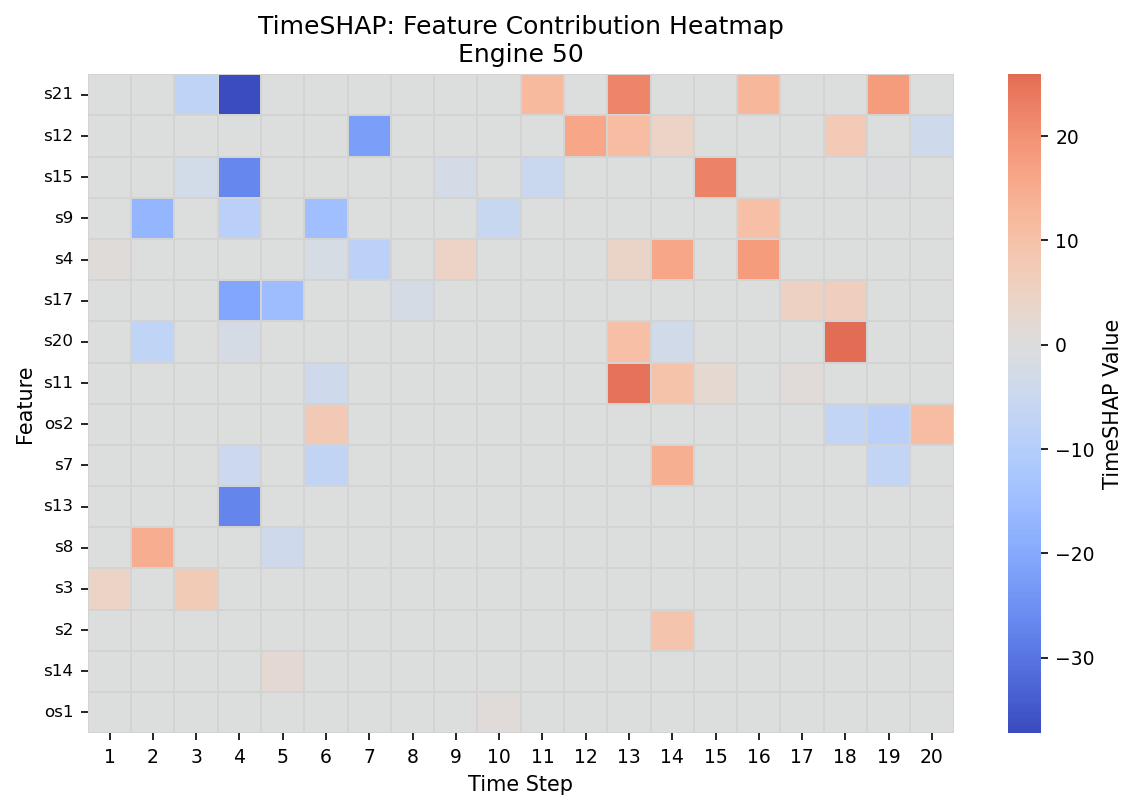

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

figure_dpi = 150
local_plot_figsize = (8, 5.5)
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 9
plots_save_dir = "plots"

engine_indices_to_plot = [0, 9, 24, 49]
engine_ids = [idx + 1 for idx in engine_indices_to_plot]

#Checking if TimeSHAP results are available
if 'ts_shap_vals' in locals() and ts_shap_vals is not None and computation_successful:

    for i, engine_idx in enumerate(engine_indices_to_plot):
        engine_id_actual = engine_ids[i]
        print(f"\n--- Generating plots for Engine {engine_id_actual} (Index {engine_idx}) ---")

        local_shap = ts_shap_vals[engine_idx]

        fig_event, ax_event = None, None
        try:
            print(f"  Generating Event Importance plot for Engine {engine_id_actual}...")
            event_importance = np.mean(np.abs(local_shap), axis=1) #Shape (window,)
            time_labels = [f"T{t+1}" for t in range(window)]
            event_series = pd.Series(event_importance, index=time_labels)
            event_series_sorted = event_series.sort_values(ascending=True)

            fig_event, ax_event = plt.subplots(figsize=local_plot_figsize, dpi=figure_dpi)
            event_series_sorted.plot.barh(ax=ax_event, color='#008bfb')

            ax_event.set_title(f"TimeSHAP: Time Step Importance\nEngine {engine_id_actual}", fontsize=title_fontsize)
            ax_event.set_xlabel("Mean |TimeSHAP Value|", fontsize=label_fontsize)
            ax_event.set_ylabel("Time Step", fontsize=label_fontsize)
            ax_event.tick_params(axis='both', labelsize=tick_fontsize)
            ax_event.spines[['top', 'right']].set_visible(False)
            plt.tight_layout()

            filename = os.path.join(save_dir, f"timeshap_time_step_importance_engine_{engine_id_actual}.png")
            plt.savefig(filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"    Event plot saved to {filename}")
            plt.show()
        except Exception as e:
            print(f"    Error generating Event Importance plot: {e}")
        finally:
            if fig_event is not None: plt.close(fig_event)


        fig_heatmap, ax_heatmap = None, None
        try:
            print(f"  Generating Cell Importance Heatmap for Engine {engine_id_actual}...")

            local_feat_magnitude = np.mean(np.abs(local_shap), axis=0) #Shape (n_features,)
            local_indices_sorted_desc = np.argsort(local_feat_magnitude)[::-1]
            local_names_sorted = np.array(base_feature_names)[local_indices_sorted_desc]
            local_heatmap_data = local_shap[:, local_indices_sorted_desc] #Shape (20, 16)

            fig_heatmap, ax_heatmap = plt.subplots(figsize=local_plot_figsize, dpi=figure_dpi)
            cmap_choice = "coolwarm"

            sns.heatmap(
                local_heatmap_data.T,
                xticklabels=np.arange(1, window + 1),
                yticklabels=local_names_sorted,
                cmap=cmap_choice,
                center=0,
                annot=False,
                linewidths=0.1,
                linecolor='lightgrey',
                cbar_kws={'label': 'TimeSHAP Value'},
                ax=ax_heatmap
            )

            ax_heatmap.set_title(f"TimeSHAP: Feature Contribution Heatmap\nEngine {engine_id_actual}", fontsize=title_fontsize)
            ax_heatmap.set_xlabel("Time Step", fontsize=label_fontsize)
            ax_heatmap.set_ylabel("Feature", fontsize=label_fontsize)
            ax_heatmap.tick_params(axis='x', labelsize=tick_fontsize, rotation=0)
            ax_heatmap.tick_params(axis='y', labelsize=tick_fontsize-1, rotation=0)
            cbar = ax_heatmap.collections[0].colorbar
            cbar.ax.yaxis.label.set_size(label_fontsize)
            cbar.ax.tick_params(labelsize=tick_fontsize)
            plt.tight_layout()

            filename = os.path.join(plots_save_dir, f"timeshap_feature_contribution_heatmap_engine_{engine_id_actual}.png")
            plt.savefig(filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"    Heatmap saved to {filename}")
            plt.show()
        except Exception as e:
            print(f"    Error generating Heatmap plot: {e}")
        finally:
            if fig_heatmap is not None: plt.close(fig_heatmap)

else:
    print("\nSkipping Local TimeSHAP plotting as values were not computed successfully.")


--- Generating combined plot for Engine 1 (Index 0) ---
  Generating Event Importance subplot...
  Generating Cell Importance Heatmap subplot...
    Combined plot saved to plots\timeshap_local_explanation_engine_1.png


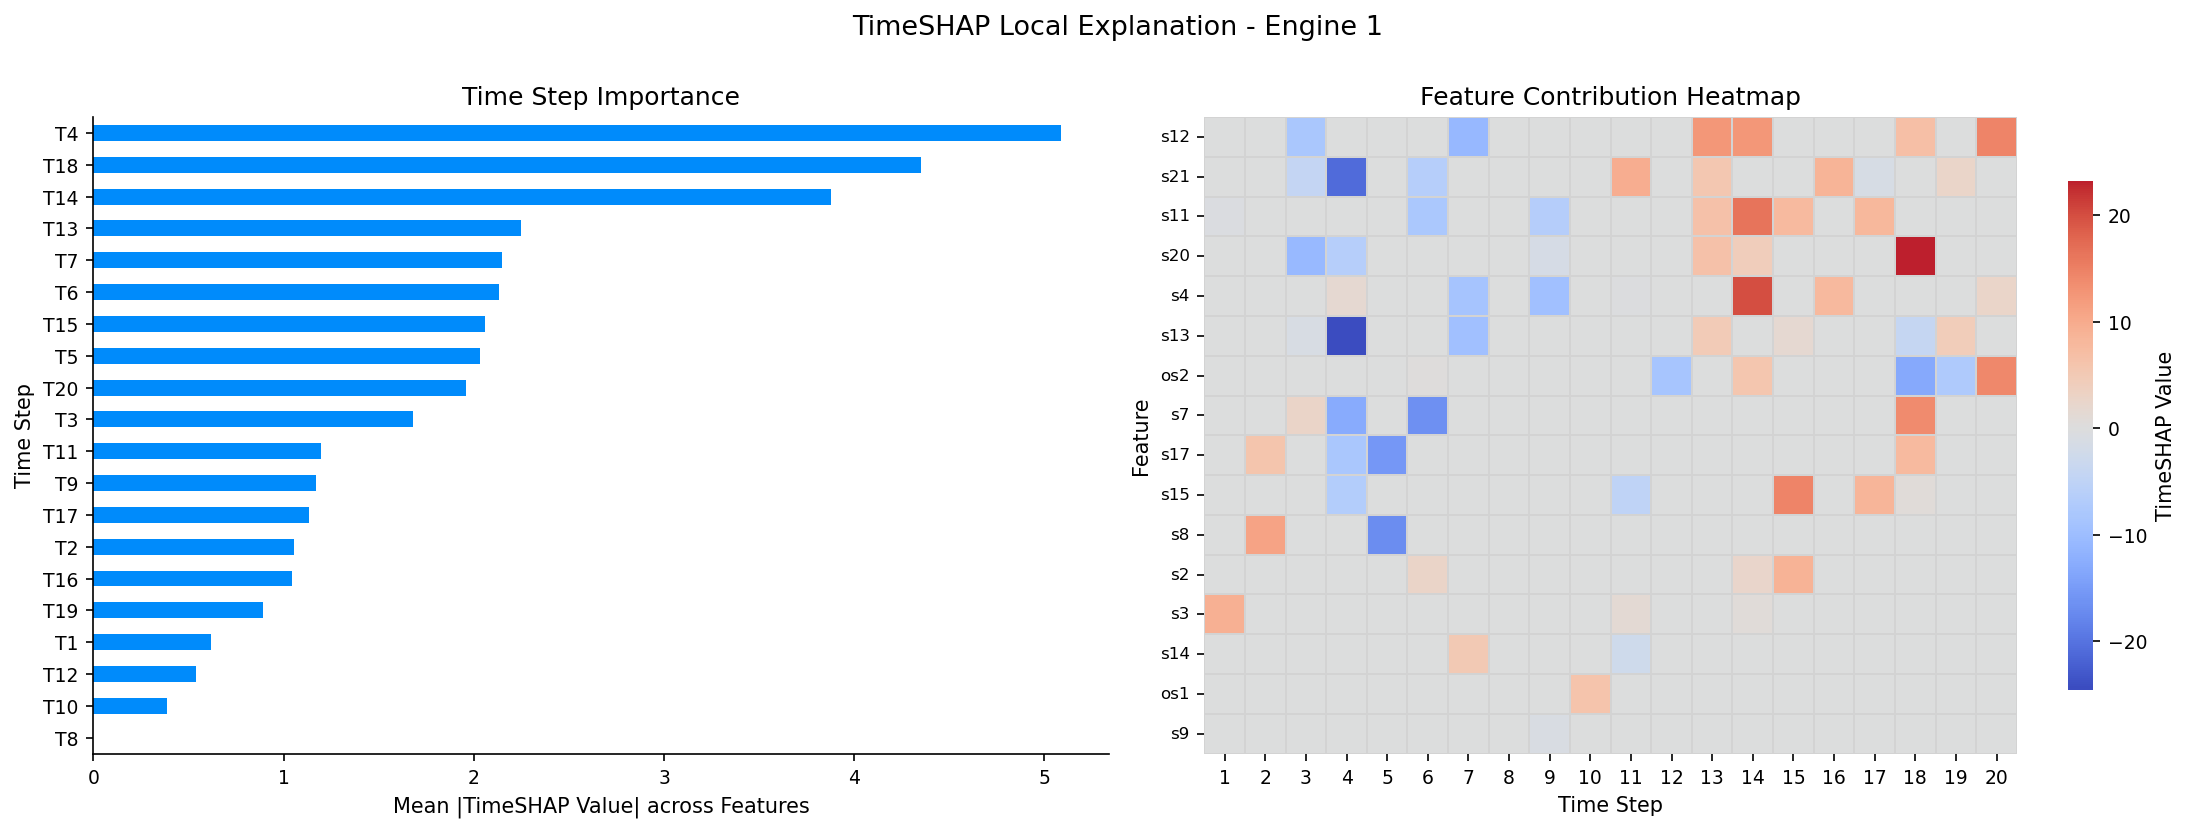


--- Generating combined plot for Engine 10 (Index 9) ---
  Generating Event Importance subplot...
  Generating Cell Importance Heatmap subplot...
    Combined plot saved to plots\timeshap_local_explanation_engine_10.png


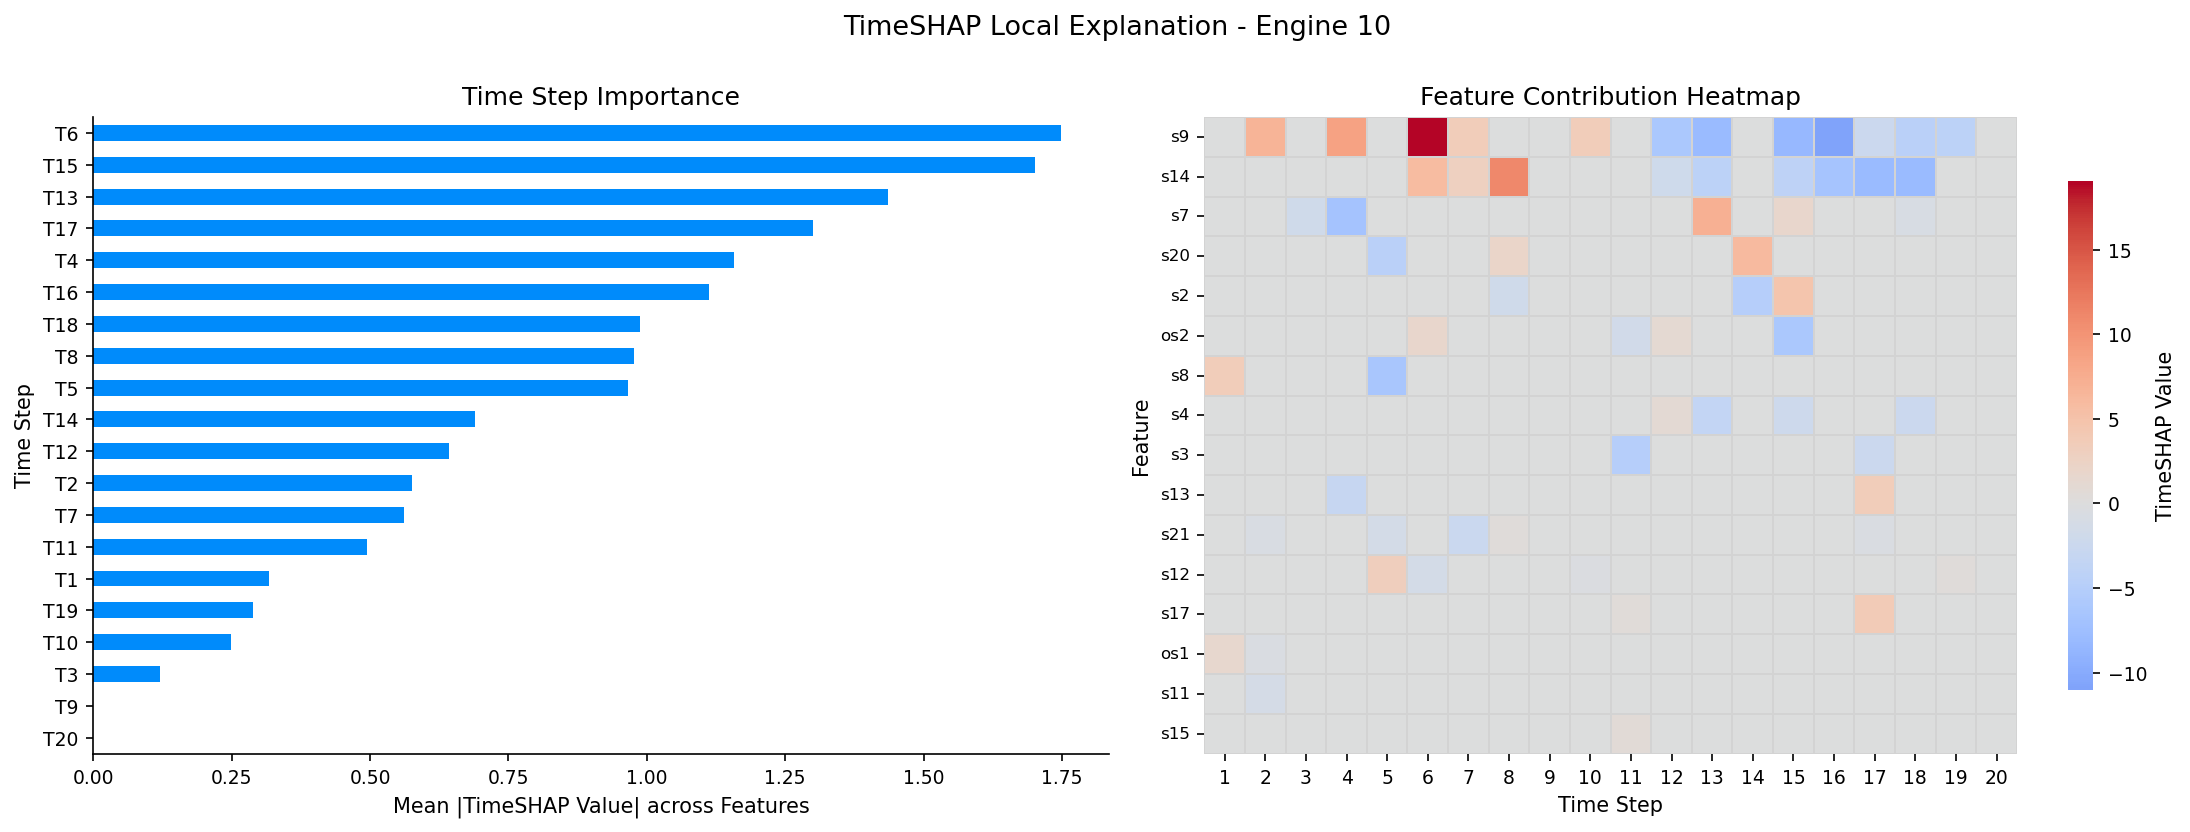


--- Generating combined plot for Engine 25 (Index 24) ---
  Generating Event Importance subplot...
  Generating Cell Importance Heatmap subplot...
    Combined plot saved to plots\timeshap_local_explanation_engine_25.png


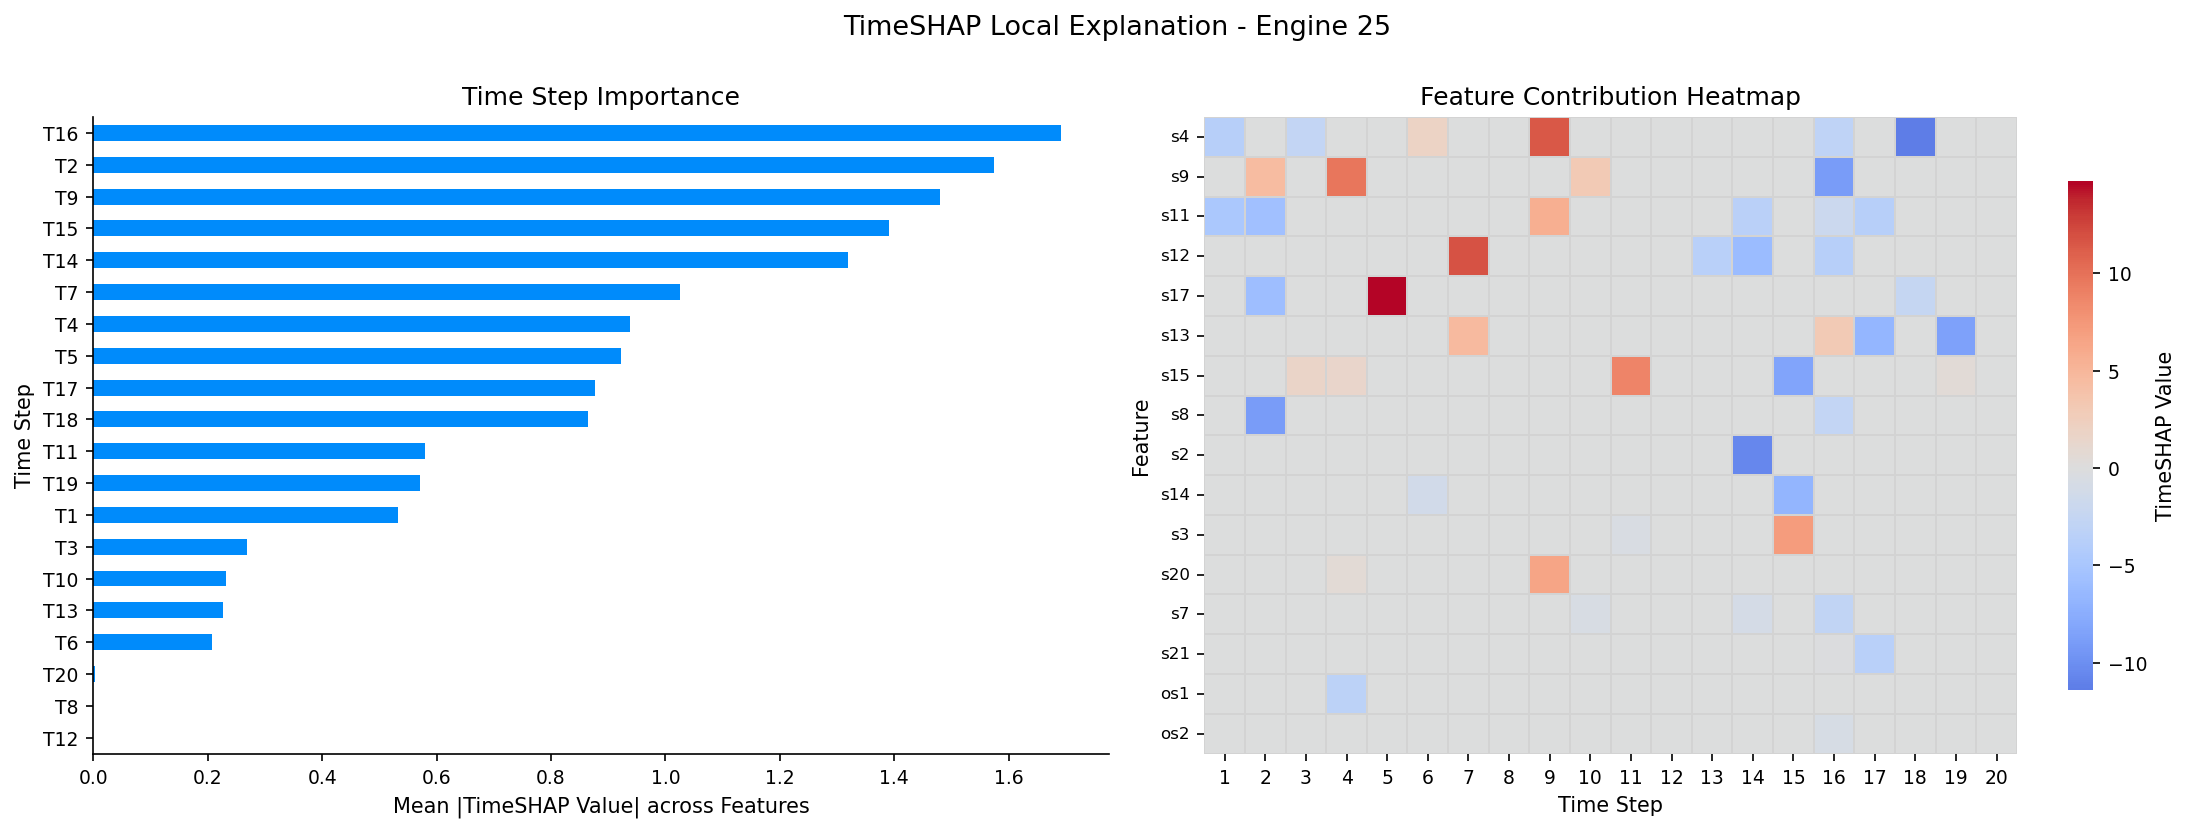


--- Generating combined plot for Engine 50 (Index 49) ---
  Generating Event Importance subplot...
  Generating Cell Importance Heatmap subplot...
    Combined plot saved to plots\timeshap_local_explanation_engine_50.png


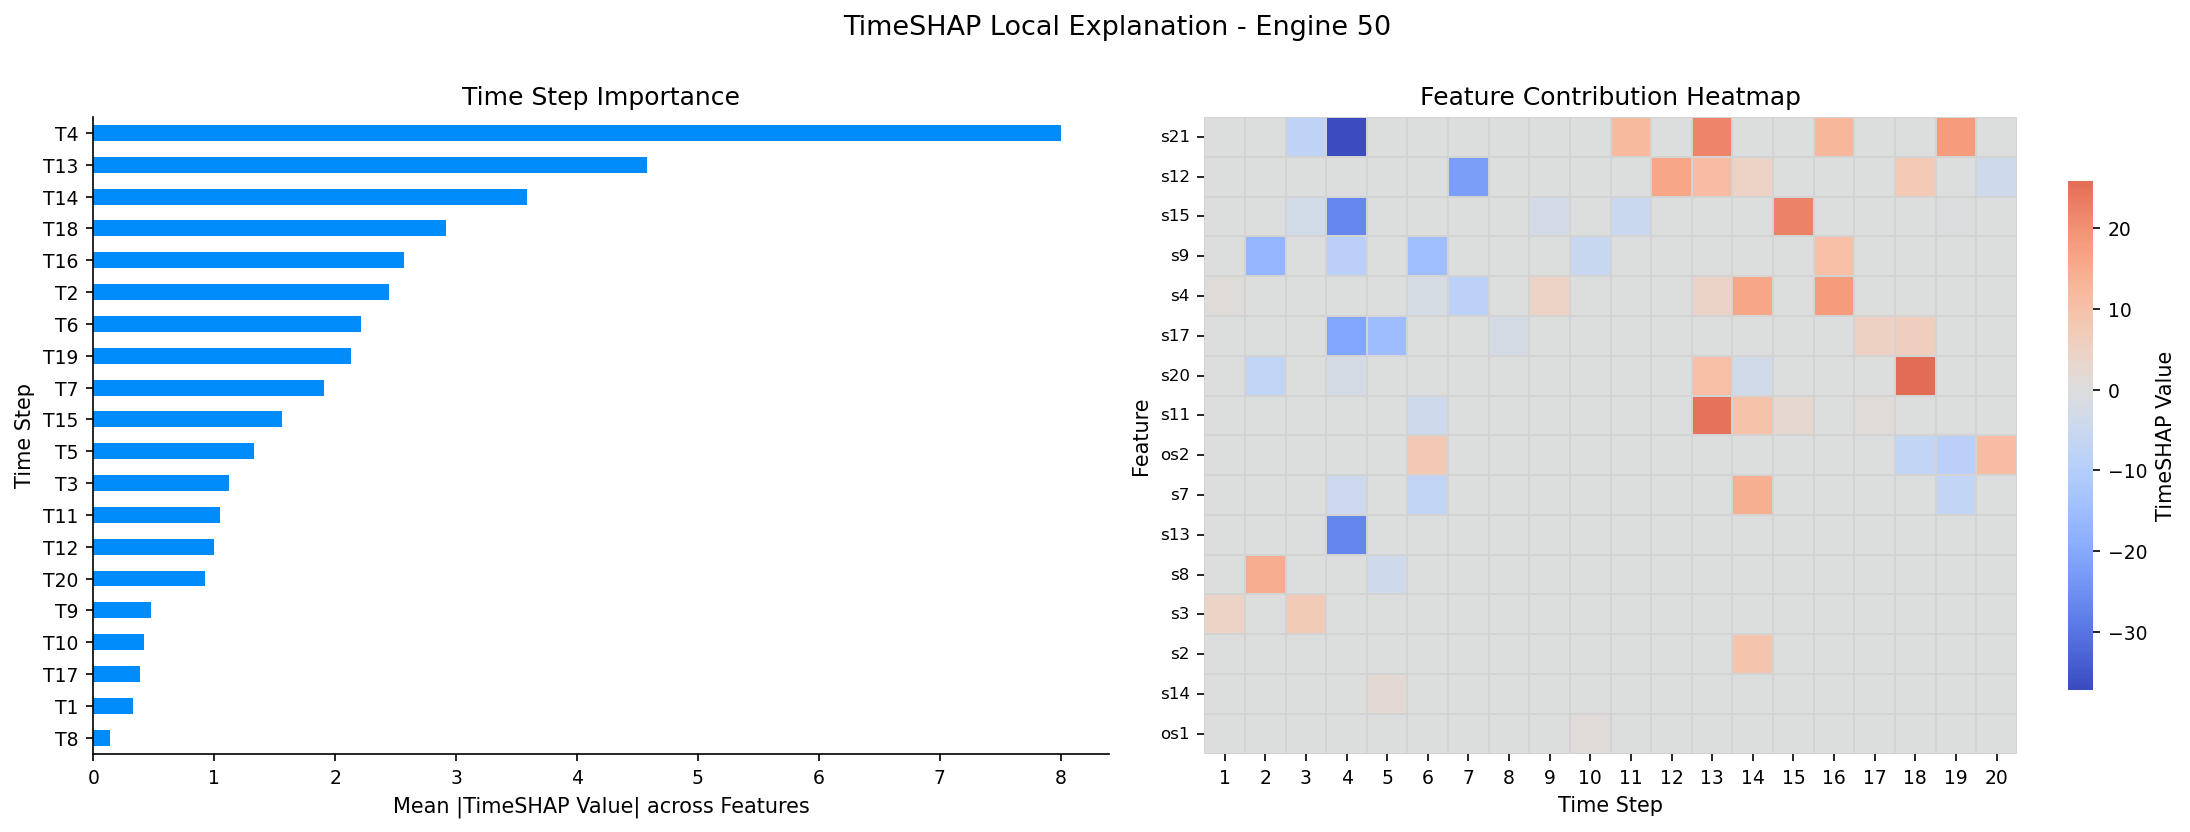

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

figure_dpi = 150
combined_local_figsize = (15, 5.5)
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 9
plots_save_dir = "plots"

engine_indices_to_plot = [0, 9, 24, 49]
engine_ids = [idx + 1 for idx in engine_indices_to_plot]


if 'ts_shap_vals' in locals() and ts_shap_vals is not None and computation_successful:

    for i, engine_idx in enumerate(engine_indices_to_plot):
        engine_id_actual = engine_ids[i]
        print(f"\n--- Generating combined plot for Engine {engine_id_actual} (Index {engine_idx}) ---")

        local_shap = ts_shap_vals[engine_idx]

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=combined_local_figsize, dpi=figure_dpi)
        fig.suptitle(f"TimeSHAP Local Explanation - Engine {engine_id_actual}", fontsize=title_fontsize+1, y=1.0)

        plot_success_flags = [False, False]

        try:
            ax_event = axes[0]
            print(f"  Generating Event Importance subplot...")
            event_importance = np.mean(np.abs(local_shap), axis=1)
            time_labels = [f"T{t+1}" for t in range(window)]
            event_series = pd.Series(event_importance, index=time_labels)
            event_series_sorted = event_series.sort_values(ascending=True)

            event_series_sorted.plot.barh(ax=ax_event, color='#008bfb')

            ax_event.set_title(f"Time Step Importance", fontsize=title_fontsize)
            ax_event.set_xlabel("Mean |TimeSHAP Value| across Features", fontsize=label_fontsize)
            ax_event.set_ylabel("Time Step", fontsize=label_fontsize)
            ax_event.tick_params(axis='both', labelsize=tick_fontsize)
            ax_event.spines[['top', 'right']].set_visible(False)
            plot_success_flags[0] = True
        except Exception as e:
            print(f"    Error generating Event Importance subplot: {e}")
            if 'ax_event' in locals(): ax_event.set_title("Error", fontsize=title_fontsize)

        try:
            ax_heatmap = axes[1]
            print(f"  Generating Cell Importance Heatmap subplot...")

            local_feat_magnitude = np.mean(np.abs(local_shap), axis=0)
            local_indices_sorted_desc = np.argsort(local_feat_magnitude)[::-1]
            local_names_sorted = np.array(base_feature_names)[local_indices_sorted_desc]
            local_heatmap_data = local_shap[:, local_indices_sorted_desc]

            cmap_choice = "coolwarm"
            sns.heatmap(
                local_heatmap_data.T,
                xticklabels=np.arange(1, window + 1),
                yticklabels=local_names_sorted,
                cmap=cmap_choice,
                center=0,
                annot=False,
                linewidths=0.1,
                linecolor='lightgrey',
                cbar_kws={'label': 'TimeSHAP Value', 'shrink': 0.8},
                ax=ax_heatmap
            )

            ax_heatmap.set_title(f"Feature Contribution Heatmap", fontsize=title_fontsize)
            ax_heatmap.set_xlabel("Time Step", fontsize=label_fontsize)
            ax_heatmap.set_ylabel("Feature", fontsize=label_fontsize)
            ax_heatmap.tick_params(axis='x', labelsize=tick_fontsize, rotation=0)
            ax_heatmap.tick_params(axis='y', labelsize=tick_fontsize-1, rotation=0)
            cbar = ax_heatmap.collections[0].colorbar
            cbar.ax.yaxis.label.set_size(label_fontsize)
            cbar.ax.tick_params(labelsize=tick_fontsize)

            plot_success_flags[1] = True
        except Exception as e:
            print(f"    Error generating Heatmap subplot: {e}")
            if 'ax_heatmap' in locals(): ax_heatmap.set_title("Error", fontsize=title_fontsize)


        if all(plot_success_flags):
             try:
                 plt.tight_layout(rect=[0, 0, 1, 1])
                 filename = os.path.join(plots_save_dir, f"timeshap_local_explanation_engine_{engine_id_actual}.png")
                 plt.savefig(filename, dpi=figure_dpi, bbox_inches='tight')
                 print(f"    Combined plot saved to {filename}")
             except Exception as save_err:
                 print(f"    Error saving combined plot: {save_err}")

        plt.show()
        plt.close(fig)

else:
    print("\nSkipping Local TimeSHAP plotting as values were not computed successfully.")

Preparing data for top 16 features...
Data prepared for: ['s12', 's9', 's4', 's20', 's13', 's21', 's11', 'os2', 's7', 's14', 's8', 's15', 's17', 's2', 's3', 'os1']

Generating Magnitude heatmap...
Magnitude heatmap saved to plots\timeshap_feature_importance_heatmap.png


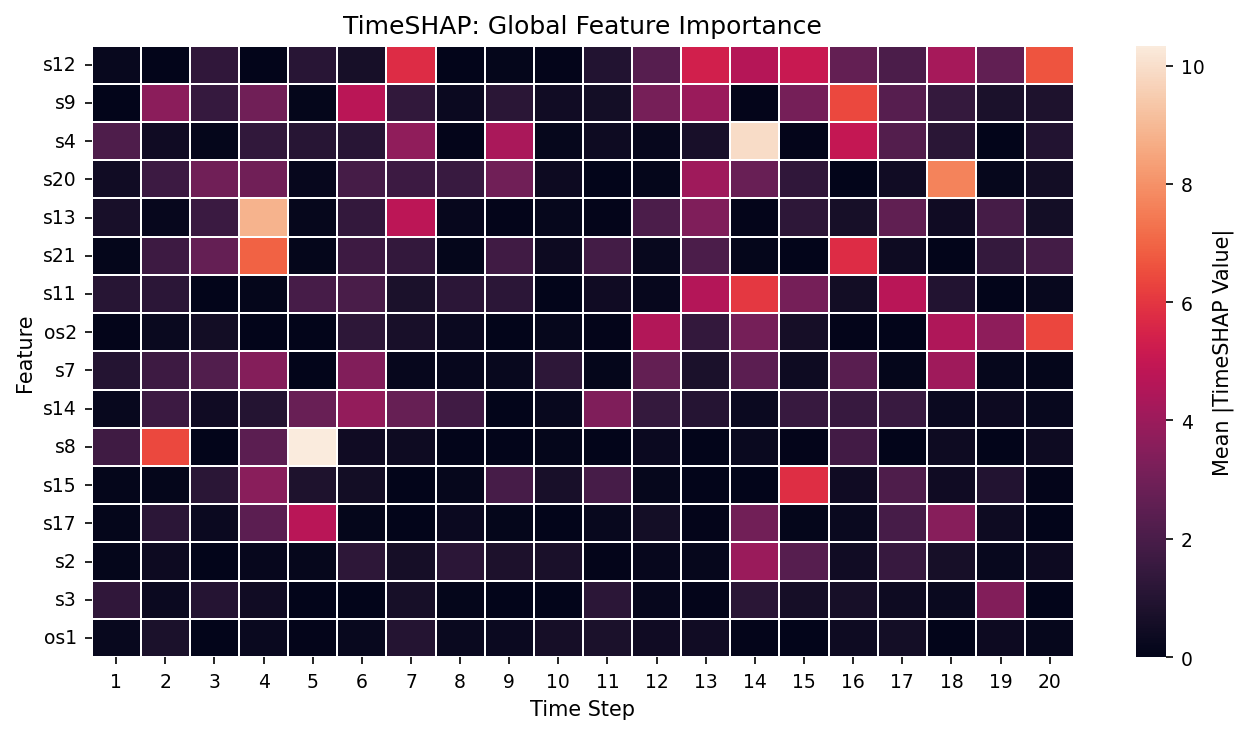


Generating Signed Mean heatmap...
Signed heatmap saved to plots\timeshap_feature_contribution_heatmap.png


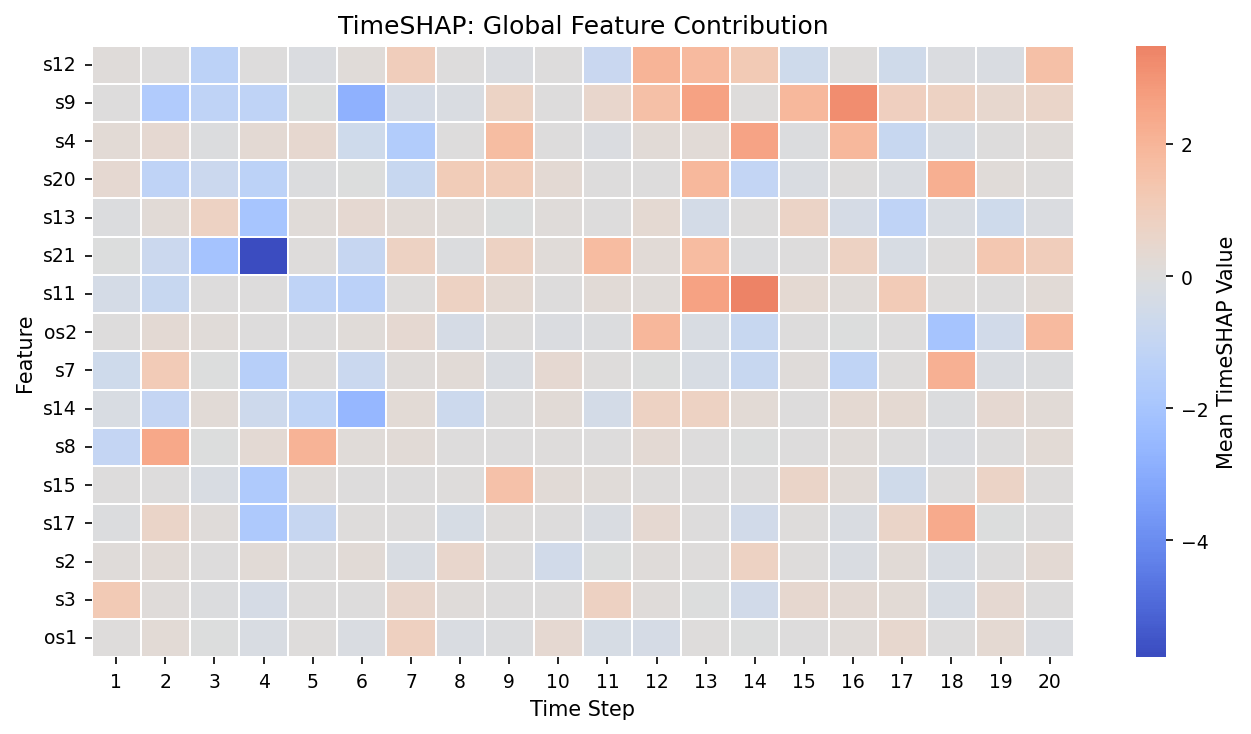

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

figure_dpi = 150
heatmap_figsize = (9, 5)
title_fontsize = 12
label_fontsize = 10
tick_fontsize = 9
n_top_features_heatmap = 16
plots_save_dir = "plots"


if 'ts_shap_vals' in locals() and ts_shap_vals is not None and computation_successful:

    print(f"Preparing data for top {n_top_features_heatmap} features...")
    data_ready = False
    try:
        overall_magnitude = np.mean(np.abs(ts_shap_vals), axis=(0, 1))
        top_feature_indices = np.argsort(overall_magnitude)[-n_top_features_heatmap:]
        top_feature_indices_sorted = top_feature_indices[np.argsort(overall_magnitude[top_feature_indices])[::-1]]
        top_feature_names_sorted = np.array(base_feature_names)[top_feature_indices_sorted]

        mean_abs_shap_time = np.mean(np.abs(ts_shap_vals), axis=0) #Shape (window, n_features)
        mean_signed_shap_time = np.mean(ts_shap_vals, axis=0)    #Shape (window, n_features)

        heatmap_data_abs = mean_abs_shap_time[:, top_feature_indices_sorted]    #Shape (window, n_top)
        heatmap_data_signed = mean_signed_shap_time[:, top_feature_indices_sorted] #Shape (window, n_top)

        print(f"Data prepared for: {top_feature_names_sorted.tolist()}")
        data_ready = True
    except Exception as calc_err:
        print(f"Error during pre-calculation for heatmaps: {calc_err}")

    if data_ready:
        fig_abs, ax_abs = None, None
        try:
            print(f"\nGenerating Magnitude heatmap...")
            fig_abs, ax_abs = plt.subplots(figsize=heatmap_figsize, dpi=figure_dpi)
            cmap_abs = "rocket"

            sns.heatmap(
                heatmap_data_abs.T,
                xticklabels=np.arange(1, window + 1), yticklabels=top_feature_names_sorted,
                cmap=cmap_abs, annot=False, linewidths=0.1,
                cbar_kws={'label': 'Mean |TimeSHAP Value|'}, ax=ax_abs
            )
            ax_abs.set_title(f"TimeSHAP: Global Feature Importance", fontsize=title_fontsize)
            ax_abs.set_xlabel("Time Step", fontsize=label_fontsize)
            ax_abs.set_ylabel("Feature", fontsize=label_fontsize)
            ax_abs.tick_params(axis='both', labelsize=tick_fontsize, rotation=0)
            ax_abs.spines[['top', 'right']].set_visible(False)
            cbar = ax_abs.collections[0].colorbar
            cbar.ax.yaxis.label.set_size(label_fontsize)
            cbar.ax.tick_params(labelsize=tick_fontsize)

            plt.tight_layout()
            png_filename = os.path.join(plots_save_dir, f"timeshap_feature_importance_heatmap.png")
            plt.savefig(png_filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"Magnitude heatmap saved to {png_filename}")
            plt.show()
        except Exception as e:
            print(f"Error generating Magnitude TimeSHAP heatmap: {e}")
        finally:
            if fig_abs is not None: plt.close(fig_abs)


        fig_signed, ax_signed = None, None
        try:
            print(f"\nGenerating Signed Mean heatmap...")
            fig_signed, ax_signed = plt.subplots(figsize=heatmap_figsize, dpi=figure_dpi)
            cmap_signed = "coolwarm"

            sns.heatmap(
                heatmap_data_signed.T,
                xticklabels=np.arange(1, window + 1), yticklabels=top_feature_names_sorted,
                cmap=cmap_signed, center=0,
                annot=False, linewidths=0.1,
                cbar_kws={'label': 'Mean TimeSHAP Value'}, ax=ax_signed
            )
            ax_signed.set_title(f"TimeSHAP: Global Feature Contribution", fontsize=title_fontsize)
            ax_signed.set_xlabel("Time Step", fontsize=label_fontsize)
            ax_signed.set_ylabel("Feature", fontsize=label_fontsize)
            ax_signed.tick_params(axis='both', labelsize=tick_fontsize, rotation=0)
            ax_signed.spines[['top', 'right']].set_visible(False)
            cbar = ax_signed.collections[0].colorbar
            cbar.ax.yaxis.label.set_size(label_fontsize)
            cbar.ax.tick_params(labelsize=tick_fontsize)

            plt.tight_layout()
            png_filename = os.path.join(plots_save_dir, f"timeshap_feature_contribution_heatmap.png")
            plt.savefig(png_filename, dpi=figure_dpi, bbox_inches='tight')
            print(f"Signed heatmap saved to {png_filename}")
            plt.show()
        except Exception as e:
            print(f"Error generating Signed TimeSHAP heatmap: {e}")
        finally:
            if fig_signed is not None: plt.close(fig_signed)

else:
    print("\nSkipping TimeSHAP heatmap plotting as values were not computed successfully.")